# Comp1-传统组学

主要适配于传统组学的建模和刻画。典型的应用场景探究rad_score最最终临床诊断的作用。

数据的一般形式为(具体文件,文件夹名可以不同)：
1. `images`文件夹，存放研究对象所有的CT、MRI等数据。
2. `masks`文件夹, 存放手工（Manuelly）勾画的ROI区域。与images文件夹的文件意义对应。
3. `label.txt`文件，每个患者对应的标签，例如肿瘤的良恶性、5年存活状态等。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
2. 组学特征提取，如果第一步检查数据通过，则提取对应数据的特征。
3. 读取标注数据信息。
4. 特征与标注数据拼接。形成数据集。
5. 查看一些统计信息，检查数据时候存在异常点。
6. 正则化，将数据变化到服从 N~(0, 1)。
7. 通过相关系数，例如spearman、person等筛选出特征。
8. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
9. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
10. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
11. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。


### 指定数据

此模块有3个需要自己定义的参数

1. `mydir`: 数据存放的路径。
2. `labelf`: 每个样本的标注信息文件。
3. `labels`: 要让AI系统学习的目标，例如肿瘤的良恶性、T-stage等。

In [1]:
import os
import pandas as pd
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)

# 设置任务Task前缀
task_type = 'Radiomics_'
# 设置数据目录
# mydir = r'你自己数据的路径'
mydir = get_param_in_cwd('radio_dir')
if mydir == okds.ct:
    print(f'正在使用Onekey数据：{okds.ct}，如果不符合预期，请修改目录位置！')
# 对应的标签文件
group_info = get_param_in_cwd('dataset_column') or 'group'
labelf = get_param_in_cwd('label_file') or os.path.join(mydir, 'label.csv')
# 读取标签数据列名
labels = [get_param_in_cwd('task_column') or 'label']

### images和masks匹配

这里要求images和masks文件夹中的文件名必须一一对应。e.g. `1.nii.gz`为images中的一个文件，在masks文件夹必须也存在一个`1.nii.gz`文件。

当然也可以使用自定义的函数，获取解析数据。

In [2]:
from pathlib import Path
from onekey_algo.custom.components.Radiology import diagnose_3d_image_mask_settings, get_image_mask_from_dir

# 生成images和masks对，一对一的关系。也可以自定义替换。
images, masks = get_image_mask_from_dir(mydir, images=f'images', masks=f'masks')
# diagnose_3d_image_mask_settings(images, masks, verbose=True, assume_masks=[0, 1])
print(f'获取到{len(images)}个样本。')

获取到766个样本。


# 传统组学特征

使用pyradiomics提取传统组学特征，正常这块不需要修改，下面是具体的Onekey封装的接口。

```python
def extract(self, images: Union[str, List[str]], 
            masks: Union[str, List[str]], labels: Union[int, List[int]] = 1, settings=None)
"""
    * images: List结构，待提取的图像列表。
    * masks: List结构，待提取的图像对应的mask，与Images必须一一对应。
    * labels: 提取标注为什么标签的特征。默认为提取label=1的。
    * settings: 其他提取特征的参数。默认为None。

"""
```

```python
def get_label_data_frame(self, label: int = 1, column_names=None, images='images', masks='labels')
"""
    * label: 获取对应label的特征。
    * columns_names: 默认为None，使用程序设定的列名即可。
"""
```
    
```python
def get_image_mask_from_dir(root, images='images', masks='labels')
"""
    * root: 待提取特征的目录。
    * images: root目录中原始数据的文件夹名。
    * masks: root目录中标注数据的文件夹名。
"""
```


In [3]:
import warnings
import pandas as pd
 
warnings.filterwarnings("ignore")

from onekey_algo.custom.components.Radiology import ConventionalRadiomics

rad_ = None
if os.path.exists(f'features/rad_features.csv'):
    rad_data = pd.read_csv(f'features/rad_features.csv', header=0)
else:
    images, masks = get_image_mask_from_dir(mydir, images=f'images', masks=f'masks')
    # 如果要自定义一些特征提取方式，可以使用param_file。
    param_file = get_param_in_cwd('extractor_settings')
    radiomics = ConventionalRadiomics(param_file, correctMask=True)
    radiomics.extract(images, masks, workers=1, 
                      with_fd=get_param_in_cwd('with_fd'), 
                      with_top=get_param_in_cwd('with_top'),
                      with_hessian=get_param_in_cwd('with_hessian'))
    rad_data = radiomics.get_label_data_frame(label=1)
    rad_data.columns = [f"intra_{c.replace('-', '_')}" if c != 'ID' else c for c in rad_data.columns]
    rad_data.to_csv(f'features/rad_features.csv', header=True, index=False)
if rad_ is None:
    rad_ = rad_data
else:
    rad_ = pd.merge(rad_, rad_data, on='ID', how='inner')
rad_data = rad_
rad_data

ID  intra-peri_exponential_firstorder_10Percentile  \
0         bianjiePVP.nii.gz                                          12.589   
1       bijinhuanPVP.nii.gz                                           8.728   
2          caibinPVP.nii.gz                                          92.506   
3    caichengshunPVP.nii.gz                                          20.058   
4     caigengyuanPVP.nii.gz                                          22.115   
..                      ...                                             ...   
761      zzC3N-02997.nii.gz                                          27.987   
762      zzC3N-02998.nii.gz                                           9.490   
763      zzC3N-03000.nii.gz                                           4.524   
764      zzC3N-03007.nii.gz                                           5.413   
765      zzC3N-03670.nii.gz                                          24.073   

     intra-peri_exponential_firstorder_90Percentile  \
0                                           268.840   
1                                           244.275   
2                                           427.609   
3                                           147.595   
4                                           293.827   
..                                              ...   
761                                         247.162   
762                                         135.874   
763                                         145.264   
764                                          96.823   
765                                         243.673   

     intra-peri_exponential_firstorder_Energy  \
0                                   8.833e+10   
1                                   1.190e+10   
2                                   8.022e+08   
3                                   6.758e+09   
4                                   1.170e+10   
..                                        ...   
761                                 2.157e+10   
762                                 1.455e+10   
763                                 1.721e+10   
764                                 3.365e+10   
765                                 5.266e+09   

     intra-peri_exponential_firstorder_Entropy  \
0                                        3.314   
1                                        3.442   
2                                        4.194   
3                                        2.935   
4                                        3.698   
..                                         ...   
761                                      3.657   
762                                      2.674   
763                                      2.570   
764                                      2.283   
765                                      3.673   

     intra-peri_exponential_firstorder_InterquartileRange  \
0                                               77.784      
1                                               94.970      
2                                              175.738      
3                                               65.367      
4                                               97.568      
..                                                 ...      
761                                            104.725      
762                                             49.084      
763                                             54.465      
764                                             37.897      
765                                            109.886      

     intra-peri_exponential_firstorder_Kurtosis  \
0                                        17.214   
1                                        89.645   
2                                        35.749   
3                                        23.622   
4                                        53.316   
..                                          ...   
761                                      33.875   
762                                     175.388   
763                              

## 特征统计

feature_group  count
1    firstorder    360
0          glcm    440
4          gldm    280
2         glrlm    320
3         glszm    320
5         ngtdm    100
6         shape     14

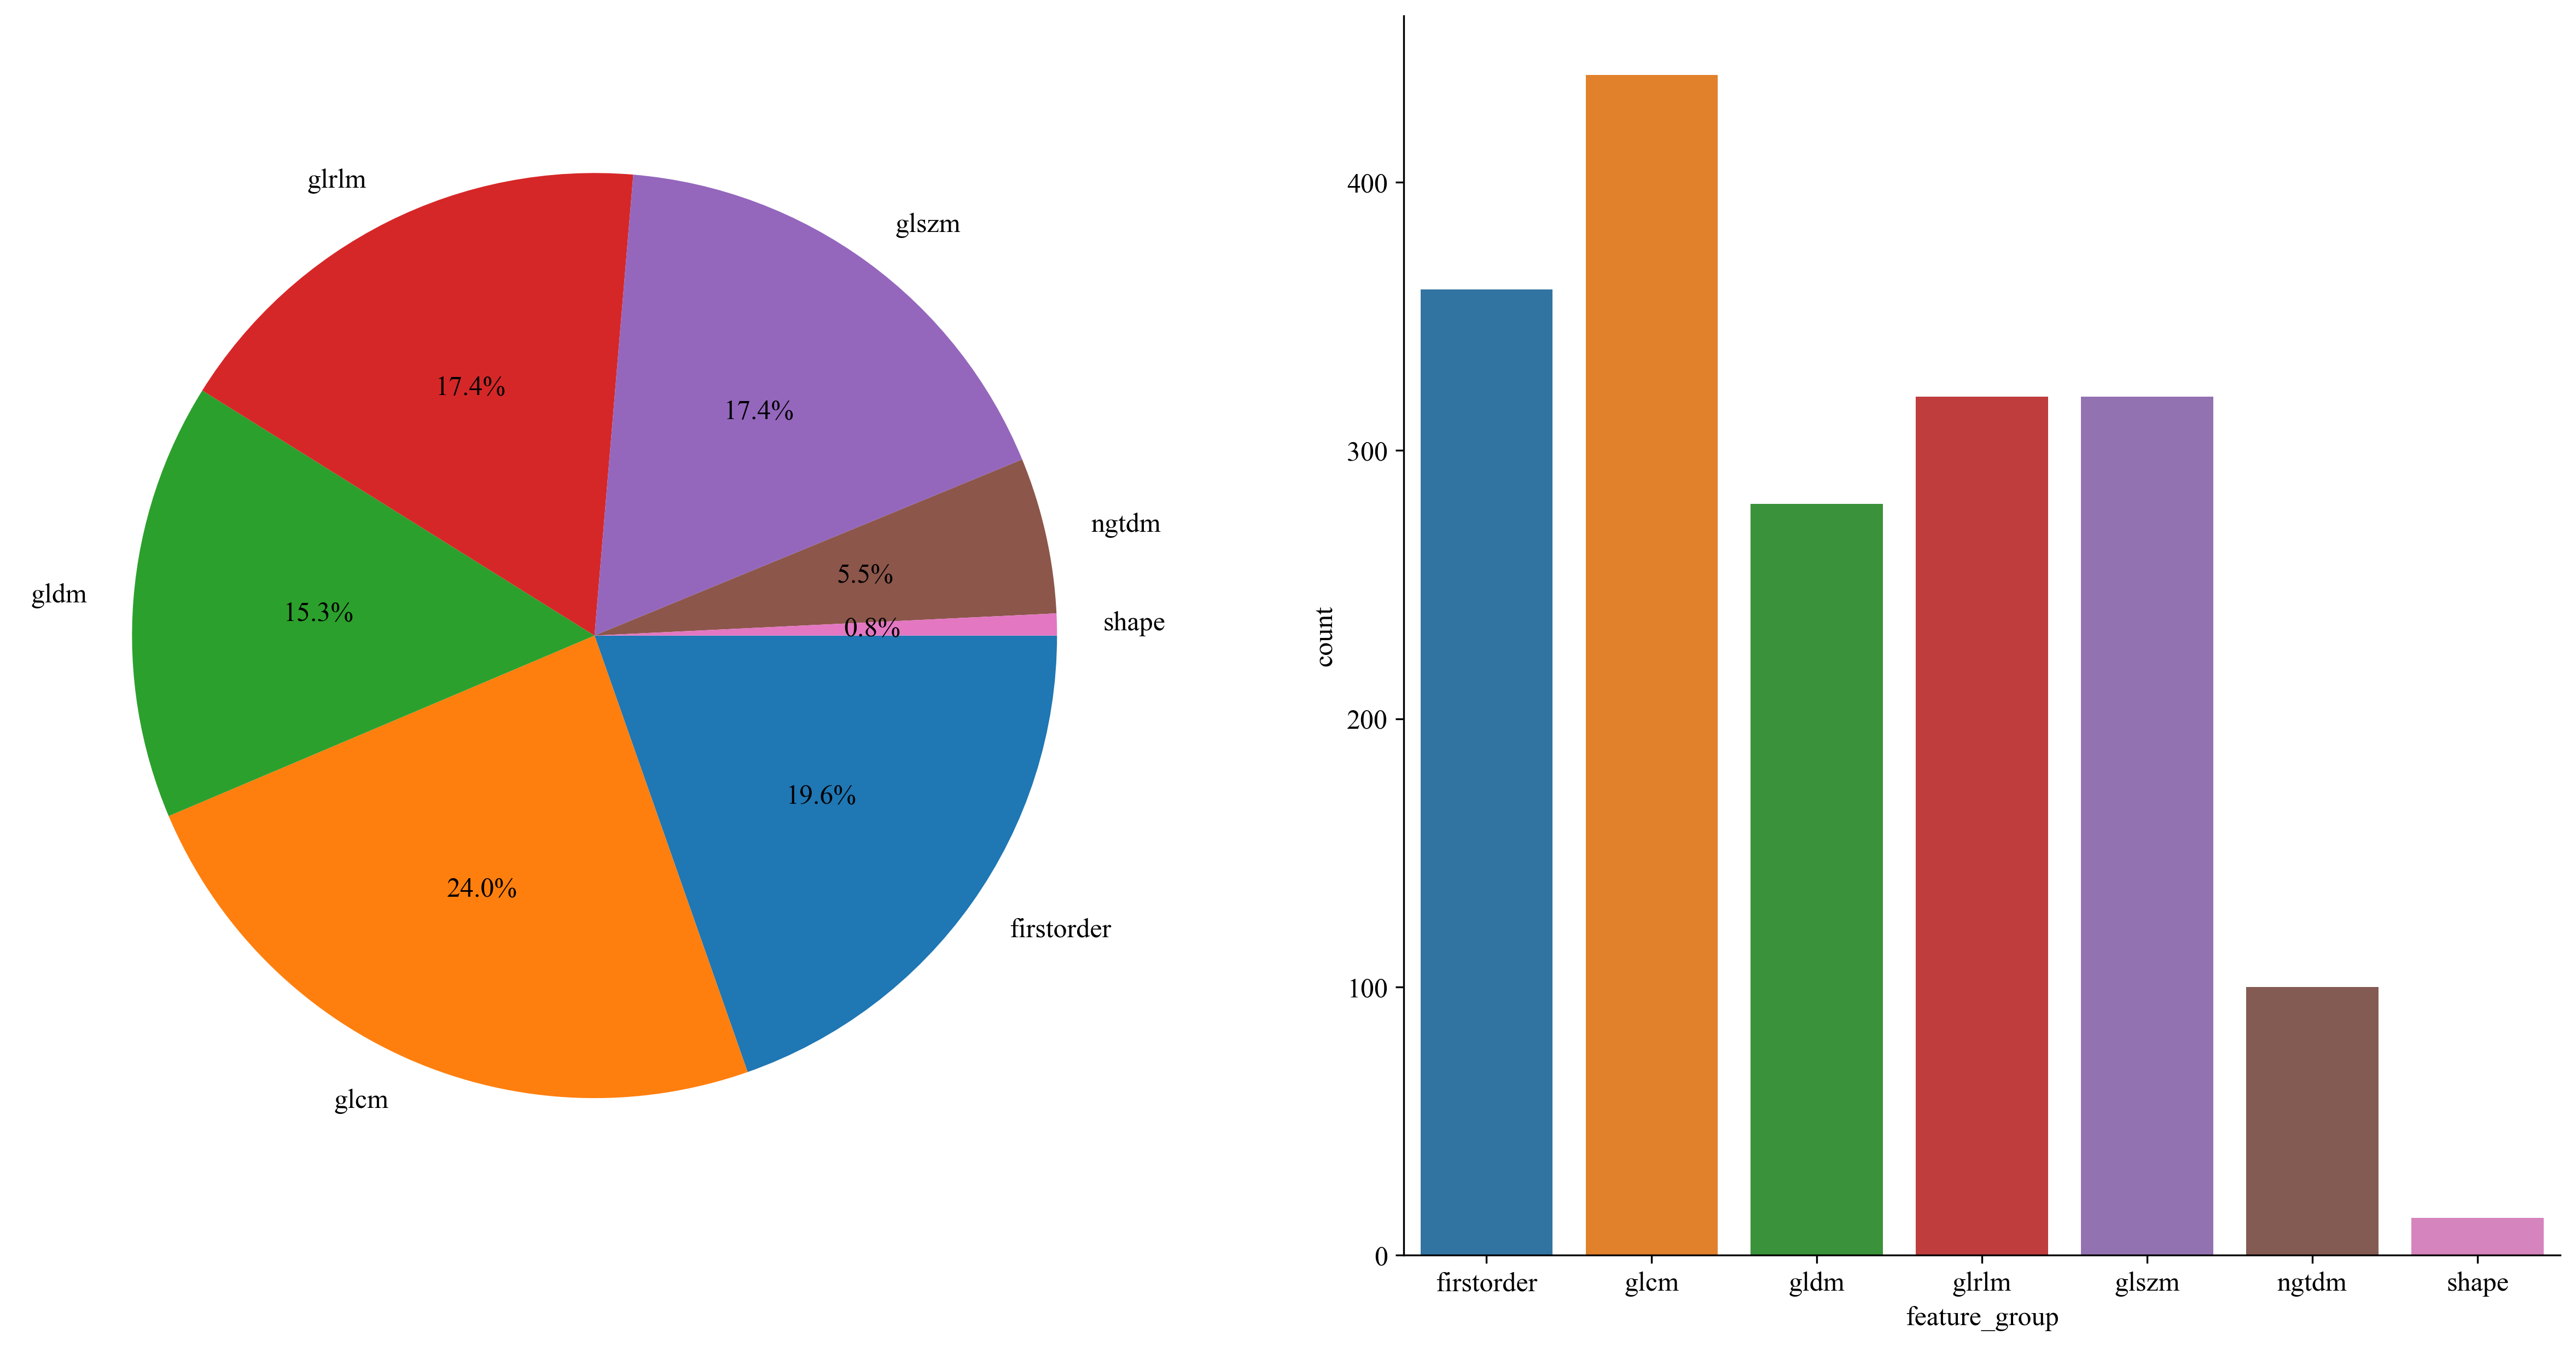

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sorted_counts = pd.DataFrame([c.split('_')[-2] for c in rad_data.columns if c !='ID']).value_counts()
sorted_counts = pd.DataFrame(sorted_counts, columns=['count']).reset_index()
sorted_counts = sorted_counts.sort_values(0)
sorted_counts.columns = ['feature_group', 'count']
display(sorted_counts)

plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
plt.pie(sorted_counts['count'], labels=[i for i in sorted_counts['feature_group']], startangle=0,
        counterclock = False, autopct = '%.1f%%')
# plt.bar_label(bar.containers[0])
ax = plt.subplot(122)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
bar = sns.barplot(data=sorted_counts, x='feature_group', y='count', )
plt.savefig(f'img/{task_type}feature_ratio.svg', bbox_inches = 'tight')

## 标注数据

数据以csv格式进行存储，这里如果是其他格式，可以使用自定义函数读取出每个样本的结果。

要求label_data为一个`DataFrame`格式，包括ID列以及后续的labels列，可以是多列，支持Multi-Task。

In [5]:
from onekey_algo.custom.components.comp1 import fillna
label_data = pd.read_csv(labelf, dtype={'ID': str})
label_data['ID'] = label_data['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
label_data

ID  event  duration  group
0       zhujiayinPVP.nii.gz      1     41.30  train
1    guochaochengPVP.nii.gz      1     16.40  train
2     xiongjiqiaoPVP.nii.gz      1     36.30  train
3    renshengyuanPVP.nii.gz      0     28.60  train
4    changjiaozhiPVP.nii.gz      1     19.87  train
..                      ...    ...       ...    ...
761      zzC3N-02997.nii.gz      1     22.40  test2
762      zzC3N-02998.nii.gz      1     21.67  test2
763      zzC3N-03000.nii.gz      1     16.23  test2
764      zzC3N-03007.nii.gz      1      1.93  test2
765      zzC3N-03670.nii.gz      1     51.10  test2

[766 rows x 4 columns]

## 特征拼接 

将标注数据`label_data`与`rad_data`进行合并，得到训练数据。

**注意：** 
1. 需要删掉ID这一列
2. 如果发现数据少了，需要自行检查数据是否匹配。

In [6]:
from onekey_algo.custom.utils import print_join_info
event_col = get_param_in_cwd('event_col')
duration_col= get_param_in_cwd('duration_col')

print_join_info(rad_data, label_data)
combined_data = pd.merge(rad_data, label_data[['ID', event_col, duration_col, 'group']], on=['ID'], how='inner')
print(combined_data[event_col].value_counts())
combined_data

[2025-12-14 16:07:12 - <frozen onekey_algo.custom.utils>:  60]	INFO	ID特征完全匹配！


1    538
0    228
Name: event, dtype: int64


ID  intra-peri_exponential_firstorder_10Percentile  \
0         bianjiePVP.nii.gz                                          12.589   
1       bijinhuanPVP.nii.gz                                           8.728   
2          caibinPVP.nii.gz                                          92.506   
3    caichengshunPVP.nii.gz                                          20.058   
4     caigengyuanPVP.nii.gz                                          22.115   
..                      ...                                             ...   
761      zzC3N-02997.nii.gz                                          27.987   
762      zzC3N-02998.nii.gz                                           9.490   
763      zzC3N-03000.nii.gz                                           4.524   
764      zzC3N-03007.nii.gz                                           5.413   
765      zzC3N-03670.nii.gz                                          24.073   

     intra-peri_exponential_firstorder_90Percentile  \
0                                           268.840   
1                                           244.275   
2                                           427.609   
3                                           147.595   
4                                           293.827   
..                                              ...   
761                                         247.162   
762                                         135.874   
763                                         145.264   
764                                          96.823   
765                                         243.673   

     intra-peri_exponential_firstorder_Energy  \
0                                   8.833e+10   
1                                   1.190e+10   
2                                   8.022e+08   
3                                   6.758e+09   
4                                   1.170e+10   
..                                        ...   
761                                 2.157e+10   
762                                 1.455e+10   
763                                 1.721e+10   
764                                 3.365e+10   
765                                 5.266e+09   

     intra-peri_exponential_firstorder_Entropy  \
0                                        3.314   
1                                        3.442   
2                                        4.194   
3                                        2.935   
4                                        3.698   
..                                         ...   
761                                      3.657   
762                                      2.674   
763                                      2.570   
764                                      2.283   
765                                      3.673   

     intra-peri_exponential_firstorder_InterquartileRange  \
0                                               77.784      
1                                               94.970      
2                                              175.738      
3                                               65.367      
4                                               97.568      
..                                                 ...      
761                                            104.725      
762                                             49.084      
763                                             54.465      
764                                             37.897      
765                                            109.886      

     intra-peri_exponential_firstorder_Kurtosis  \
0                                        17.214   
1                                        89.645   
2                                        35.749   
3                                        23.622   
4                                        53.316   
..                                          ...   
761                                      33.875   
762                                     175.388   
763                              

## 正则化

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [7]:
from onekey_algo.custom.components.comp1 import normalize_df
data = normalize_df(combined_data, not_norm=['ID', event_col, duration_col], group='group', use_train=True)
data = data.dropna(axis=1)
data.describe()

[2025-12-14 16:07:12 - <frozen onekey_algo.custom.components.comp1>: 200]	INFO	正在使用训练集预定数据进行标准化。


intra-peri_exponential_firstorder_10Percentile  \
count                                         766.000   
mean                                            0.075   
std                                             1.140   
min                                            -1.045   
25%                                            -0.542   
50%                                            -0.180   
75%                                             0.323   
max                                            14.461   

       intra-peri_exponential_firstorder_90Percentile  \
count                                         766.000   
mean                                            0.162   
std                                             1.217   
min                                            -0.782   
25%                                            -0.376   
50%                                            -0.140   
75%                                             0.251   
max                                            15.639   

       intra-peri_exponential_firstorder_Energy  \
count                                   766.000   
mean                                     -0.005   
std                                       0.884   
min                                      -0.740   
25%                                      -0.470   
50%                                      -0.253   
75%                                       0.124   
max                                      11.694   

       intra-peri_exponential_firstorder_Entropy  \
count                                    766.000   
mean                                       0.206   
std                                        1.081   
min                                       -3.078   
25%                                       -0.528   
50%                                        0.164   
75%                                        0.836   
max                                        3.574   

       intra-peri_exponential_firstorder_InterquartileRange  \
count                                            766.000      
mean                                               0.112      
std                                                1.099      
min                                               -0.593      
25%                                               -0.292      
50%                                               -0.117      
75%                                                0.164      
max                                               15.714      

       intra-peri_exponential_firstorder_Kurtosis  \
count                                     766.000   
mean                                       -0.056   
std                                         0.831   
min                                        -0.467   
25%                                        -0.378   
50%                                        -0.265   
75%                                        -0.043   
max                                        11.809   

       intra-peri_exponential_firstorder_Maximum  \
count                                    766.000   
mean                                       0.132   
std                                        0.994   
min                                       -1.767   
25%                                       -0.855   
50%                                        0.420   
75%                                        0.942   
max                                        2.208   

       intra-peri_exponential_firstorder_Mean  \
count                                 766.000   
mean                                    0.139   
std                                     1.119   
min                                    -0.933   
25%                                    -0.453   
50%                                    -0.159   
75%                                     0.347   
max                                    12.267   

       intra-peri_exponential_firstorder_MeanAbsoluteDeviation  \
count                      

In [8]:
from onekey_algo.custom.components.comp1 import normalize_df, select_feature

corr_name = get_param_in_cwd('corr_name', 'pearson')
if os.path.exists(f'features/{task_type}rad_features_sel.csv') and False:
    data = pd.read_csv(f'features/{task_type}rad_features_sel.csv', header=0)
else:
    tgroup = data[data['group'] == 'train']
    sel_feature = select_feature(tgroup[[c for c in tgroup.columns if c not in [event_col, duration_col]]].corr(corr_name), 
                                 threshold=0.9, topn=2048, verbose=False)
    data = data[['ID'] + sel_feature + [event_col, duration_col, 'group']]
    data.to_csv(f'features/{task_type}rad_features_sel.csv', header=True, index=False)
data

ID  intra-peri_exponential_firstorder_Kurtosis  \
1        bijinhuanPVP.nii.gz                                      -0.081   
3     caichengshunPVP.nii.gz                                      -0.369   
4      caigengyuanPVP.nii.gz                                      -0.239   
5       caihaimingPVP.nii.gz                                       0.598   
9       caiyoushunPVP.nii.gz                                      -0.008   
..                       ...                                         ...   
638   zhengmingzhiPVP.nii.gz                                      -0.260   
640  zhengxiaohongPVP.nii.gz                                      -0.394   
653       zhoufengPVP.nii.gz                                      -0.379   
655    zhouhanzhenPVP.nii.gz                                       0.174   
659      zhouxuhuaPVP.nii.gz                                      -0.105   

     intra-peri_exponential_firstorder_Median  \
1                                      -0.093   
3                                      -0.073   
4                                       0.122   
5                                      -0.443   
9                                      -0.530   
..                                        ...   
638                                     0.362   
640                                    -0.193   
653                                     1.120   
655                                    -0.700   
659                                    -0.422   

     intra-peri_exponential_firstorder_Range  \
1                                      1.107   
3                                     -1.056   
4                                      1.207   
5                                      0.150   
9                                      0.518   
..                                       ...   
638                                    0.317   
640                                   -1.333   
653                                    0.842   
655                                   -0.996   
659                                   -1.032   

     intra-peri_exponential_firstorder_Skewness  \
1                                         0.276   
3                                        -0.731   
4                                        -0.143   
5                                         0.930   
9                                         0.577   
..                                          ...   
638                                      -0.217   
640                                      -0.846   
653                                      -0.657   
655                                       0.063   
659                                      -0.014   

     intra-peri_exponential_glcm_Correlation  \
1                                     -1.128   
3                                     -0.243   
4                                      0.735   
5                                      0.042   
9                                     -0.591   
..                                       ...   
638                                    1.100   
640                                    0.852   
653                                   -0.610   
655                                   -0.084   
659                                    0.243   

     intra-peri_exponential_glcm_Idmn  intra-peri_exponential_glcm_Idn  \
1                               0.149                            0.116   
3                               0.179                           -0.324   
4                               0.279                            0.376   
5                               0.562                            0.857   
9                               0.137                            0.481   
..                                ...                              ...   
638                             0.323                            0.227   
640                             0.205                           -0.137   
653                            -0.775                           -1.146   
655              

## 构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

In [9]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict


train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = get_param_in_cwd('subsets')
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}{subset}_features_norm.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(381, 399)，val样本数：(164, 399)，test样本数：(163, 399)，test2样本数：(58, 399)


# 单因素Cox

如果你觉得特征比较多

**verbose**: 默认False，不输出日志。

**topk**：可以自己指定保存的topk个特征。

In [10]:
from onekey_algo.custom.components.survival import uni_cox

if os.path.exists(f'features/{task_type}rad_features_unisel.csv') and False:
    train_data = pd.read_csv(f'features/{task_type}rad_features_unisel.csv')
else:
    sel_features = uni_cox(train_data, duration_col=duration_col, event_col=event_col,
                           cols=[c for c in train_data.columns if c not in [event_col, duration_col, 'ID', 'group']], 
                           verbose=False, pvalue_thres=get_param_in_cwd('pvalue', 0.05))
    train_data = train_data[['ID'] + sel_features + [event_col, duration_col, 'group']]
    train_data.to_csv(f'features/{task_type}rad_features_unisel.csv', header=True, index=False)
train_data

ID  intra-peri_exponential_glcm_InverseVariance  \
0         bianjiePVP.nii.gz                                       -0.112   
2          caibinPVP.nii.gz                                       -1.321   
7    caiqingxiangPVP.nii.gz                                       -0.202   
10       caiyunboPVP.nii.gz                                        1.079   
12     caoguofangPVP.nii.gz                                        0.879   
..                      ...                                          ...   
670   zhuxianmingPVP.nii.gz                                        0.388   
671    zhuxiuyingPVP.nii.gz                                        0.906   
673      zoujindiPVP.nii.gz                                        0.755   
674   zoushuirongPVP.nii.gz                                        0.287   
675     zuomingqiPVP.nii.gz                                        0.548   

     intra-peri_exponential_gldm_DependenceNonUniformityNormalized  \
0                                               -0.274               
2                                                3.962               
7                                               -0.586               
10                                              -0.498               
12                                              -0.288               
..                                                 ...               
670                                              0.274               
671                                             -0.508               
673                                             -0.081               
674                                              0.566               
675                                              0.240               

     intra-peri_exponential_gldm_DependenceVariance  \
0                                            -0.166   
2                                            -2.002   
7                                             1.028   
10                                           -0.164   
12                                           -0.382   
..                                              ...   
670                                          -0.880   
671                                          -0.042   
673                                          -0.549   
674                                          -1.075   
675                                          -1.221   

     intra-peri_exponential_glrlm_ShortRunEmphasis  \
0                                            0.651   
2                                            1.967   
7                                            0.095   
10                                          -1.297   
12                                           0.319   
..                                             ...   
670                                          1.036   
671                                          0.056   
673                                          0.722   
674                                          0.365   
675                                          0.708   

     intra-peri_exponential_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                                0.144           
2                                               -2.228           
7                                               -0.093           
10                                               1.033           
12                                              -0.231           
..                                                 ...           
670                                             -0.364           
671                                              1.106           
673                                             -0.169           
674                                             -1.365           
675                                             -0.578           

     intra-peri_exponential_glszm_ZonePercentage  \
0                                          0.542   
2                                          3.182   
7           

# Cox-Lasso特征筛选

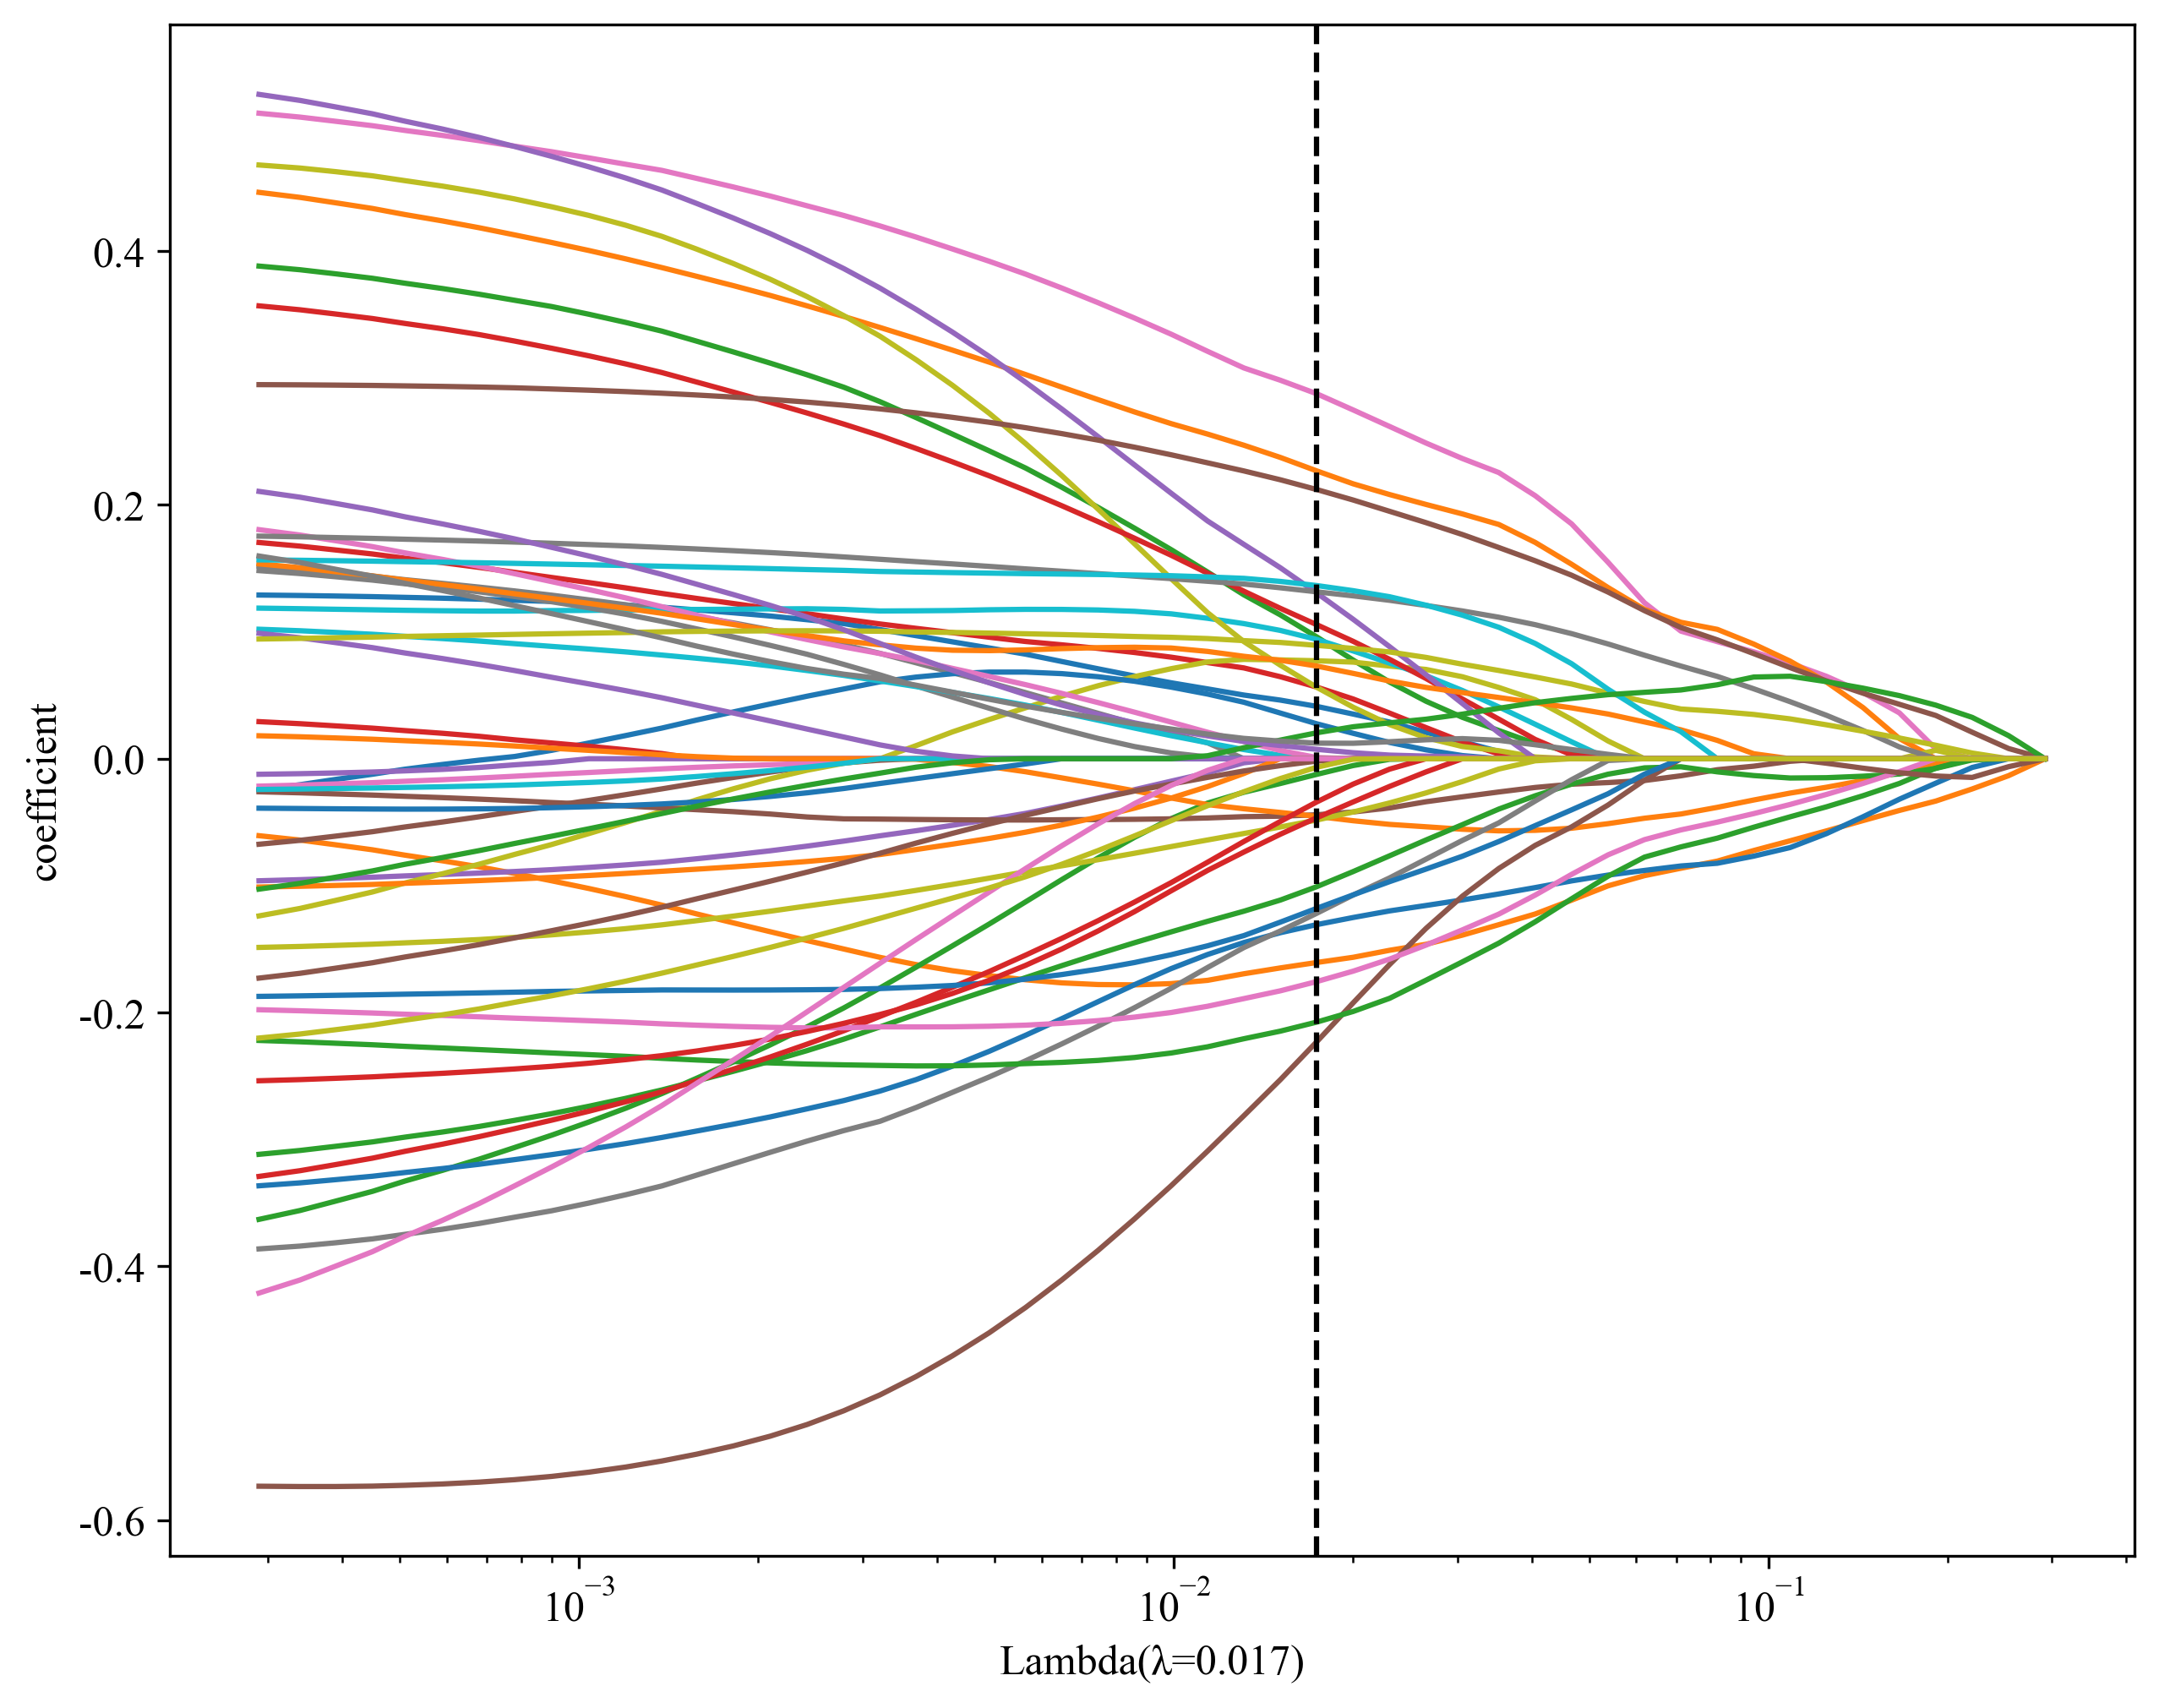

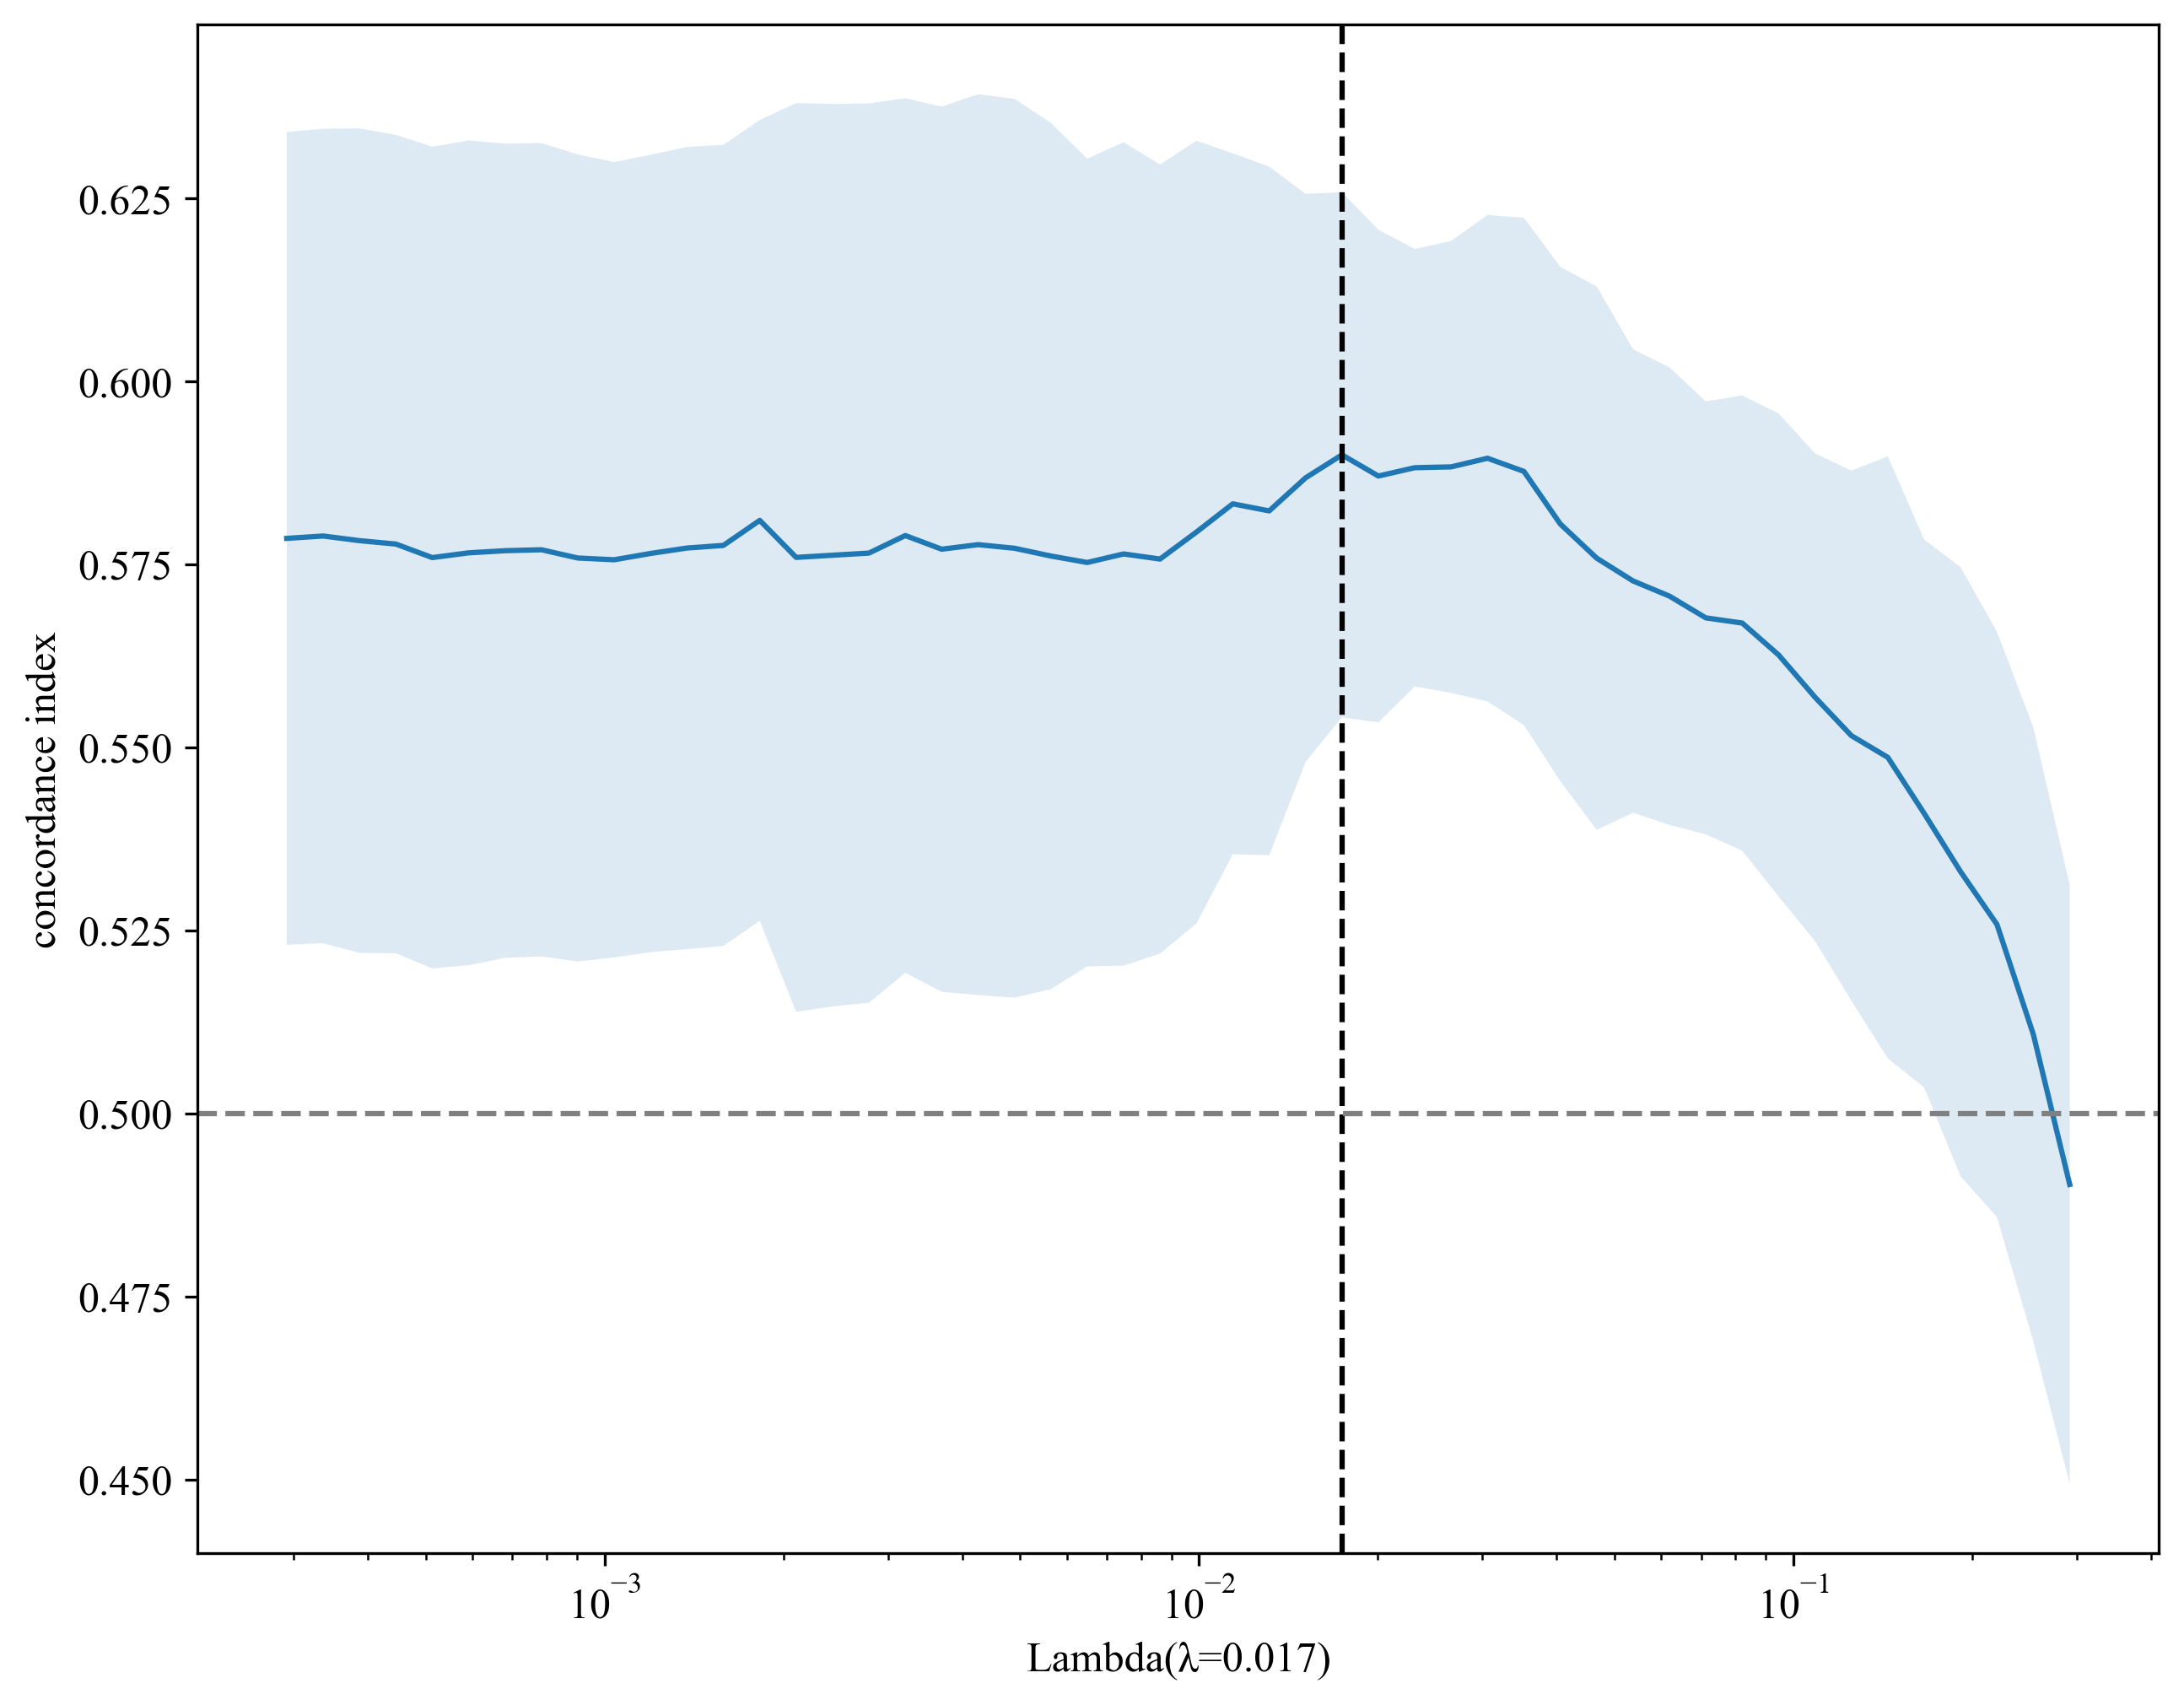

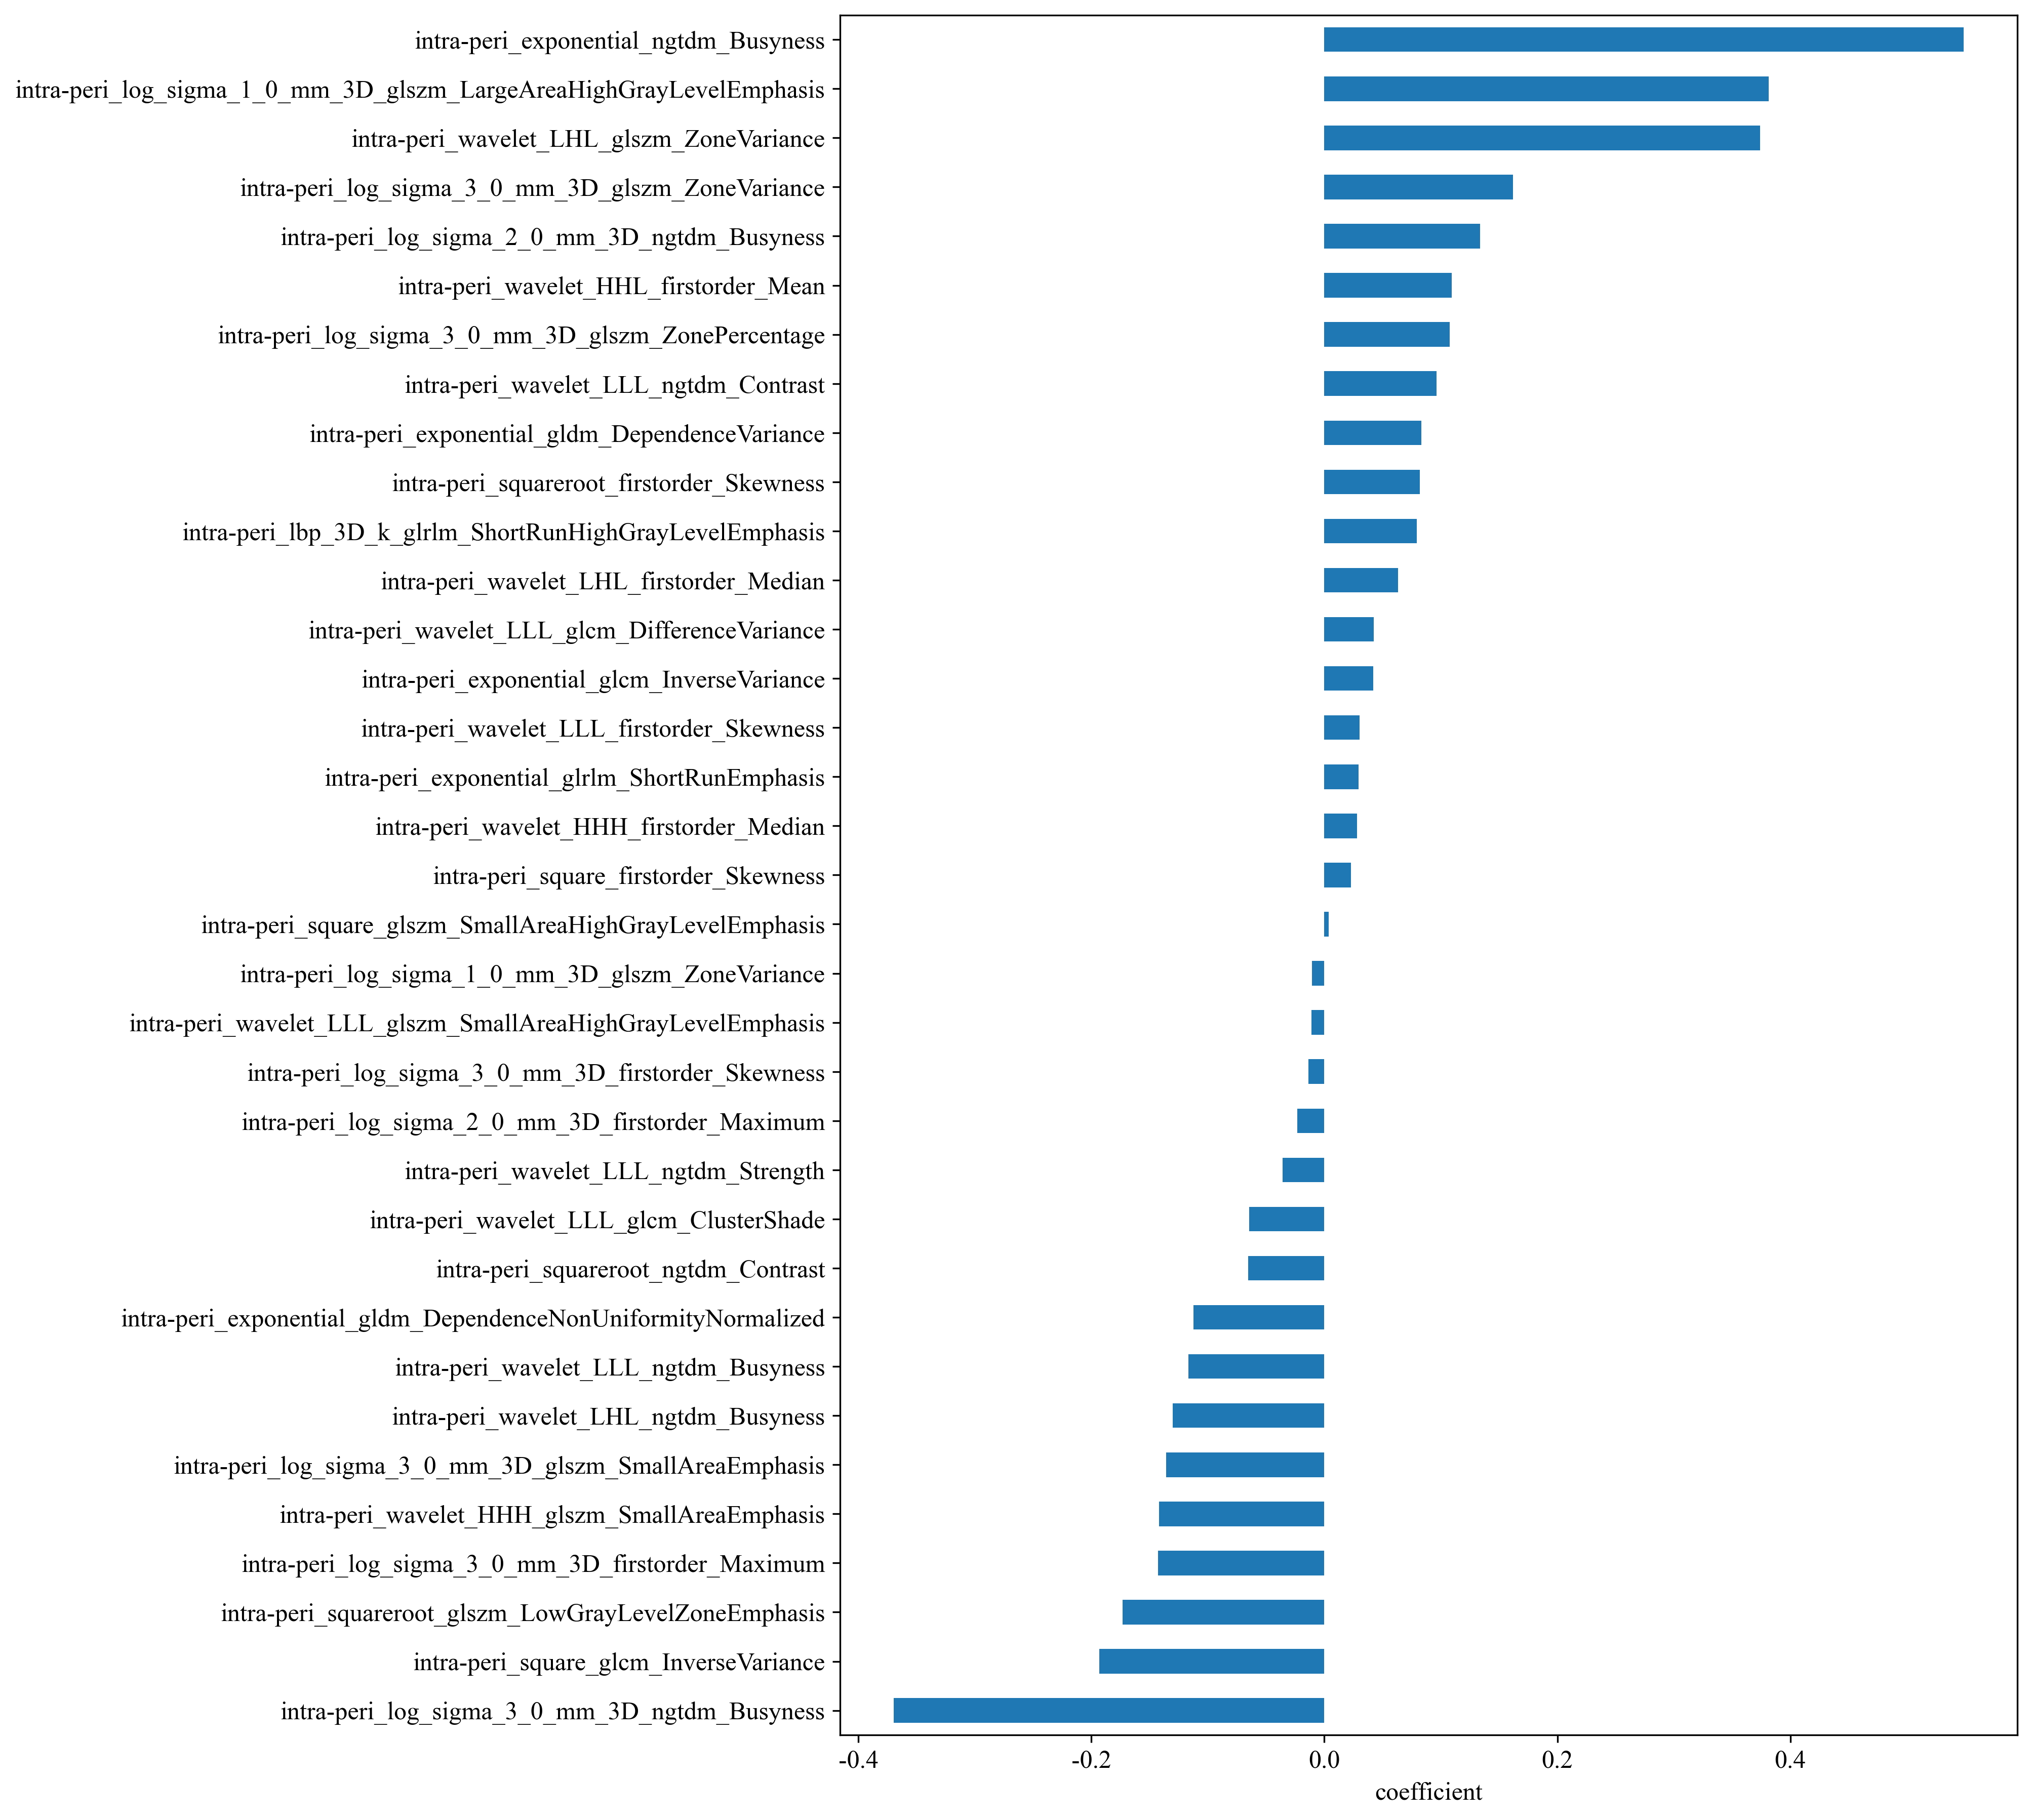

Survive = -0.369783 * intra-peri_log_sigma_3_0_mm_3D_ngtdm_Busyness -0.193159 * intra-peri_square_glcm_InverseVariance -0.173112 * intra-peri_squareroot_glszm_LowGrayLevelZoneEmphasis -0.142959 * intra-peri_log_sigma_3_0_mm_3D_firstorder_Maximum -0.141814 * intra-peri_wavelet_HHH_glszm_SmallAreaEmphasis -0.135821 * intra-peri_log_sigma_3_0_mm_3D_glszm_SmallAreaEmphasis -0.130106 * intra-peri_wavelet_LHL_ngtdm_Busyness -0.116742 * intra-peri_wavelet_LLL_ngtdm_Busyness -0.112484 * intra-peri_exponential_gldm_DependenceNonUniformityNormalized -0.065588 * intra-peri_squareroot_ngtdm_Contrast -0.064458 * intra-peri_wavelet_LLL_glcm_ClusterShade -0.035931 * intra-peri_wavelet_LLL_ngtdm_Strength -0.023228 * intra-peri_log_sigma_2_0_mm_3D_firstorder_Maximum -0.013576 * intra-peri_log_sigma_3_0_mm_3D_firstorder_Skewness -0.011266 * intra-peri_wavelet_LLL_glszm_SmallAreaHighGrayLevelEmphasis -0.010542 * intra-peri_log_sigma_1_0_mm_3D_glszm_ZoneVariance +0.003798 * intra-peri_square_glszm_SmallAr

In [11]:
from onekey_algo.custom.components.survival import get_x_y_survival, lasso_cox_cv
COEF_THRESHOLD = 1e-6

X, y = get_x_y_survival(train_data, val_outcome=1, event_col=event_col, duration_col=duration_col)
sel_features = lasso_cox_cv(X, y, max_iter=100,  norm_X=False, prefix=f"{task_type}", l1_ratio=0.5, cv=10, weights_fig_size=(10, 15))

### 筛选特征

使用Lasso-Cox之后的特征。

In [12]:
train_data = train_data[['ID'] + list(sel_features.index) + [event_col, duration_col]]
for subset in subsets:
    val_datasets[subset] = val_datasets[subset][['ID'] + list(sel_features.index) + [event_col, duration_col]]
    val_datasets[subset].to_csv(f'features/{task_type}{subset}_cox.csv', index=False)

### 聚类分析

通过修改变量名，可以可视化不同相关系数下的相聚类分析矩阵。

注意：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

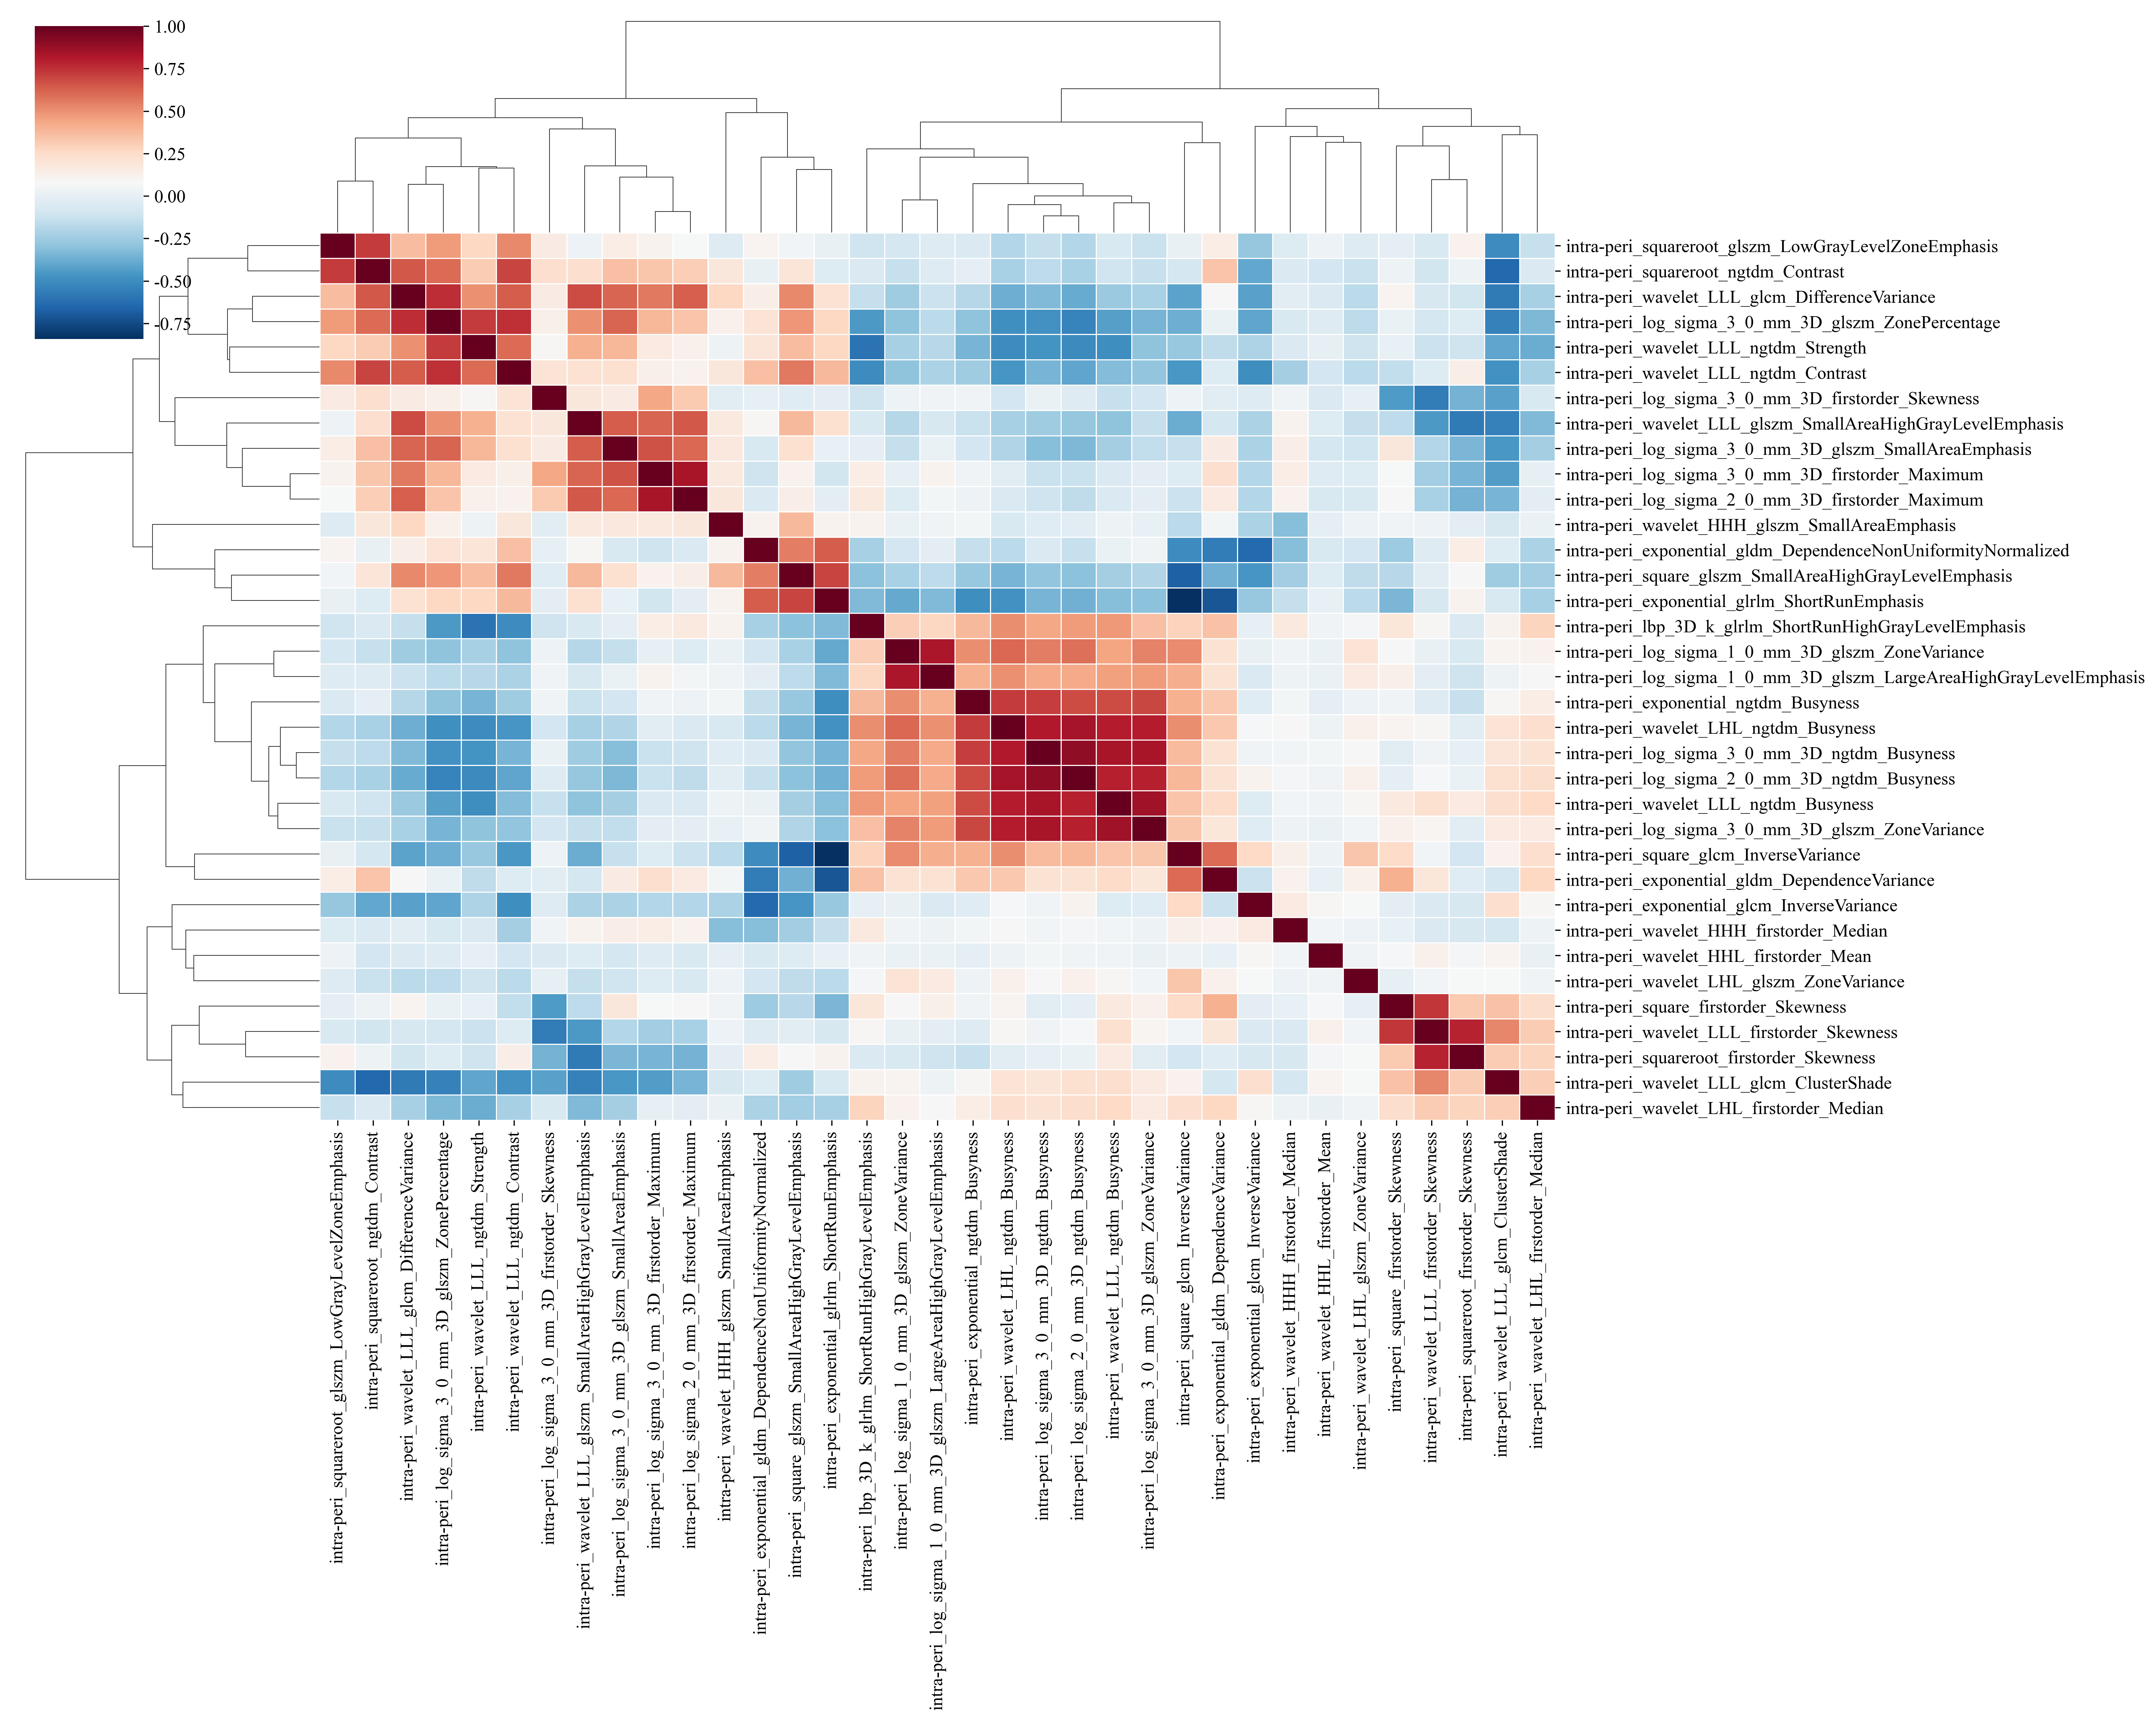

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

if train_data.shape[1] < 150:
    pp = sns.clustermap(train_data[[c for c in train_data.columns if c not in [event_col, duration_col]]].corr(corr_name), 
                        linewidths=.5, figsize=(20.0, 16.0), cmap='RdBu_r')
    plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
    plt.savefig(f'img/{task_type}feature_cluster.svg', bbox_inches = 'tight')

In [14]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(train_data[[c for c in train_data.columns if c != 'ID']], duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 381 total observations, 95 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 381
number of events observed = 286
   partial log-likelihood = -1457.82
         time fit was run = 2025-12-14 08:07:42 UTC

---
                                                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                                   
intra-peri_log_sigma_3_0_mm_3D_ngtdm_Busyness                        -0.19       0.83       0.11            -0.41             0.03                 0.67                 1.03
intra-peri_square_glcm_InverseVariance                               -0.10       0.90       0.11            -0.31             0.11                 0.73                 1.11
intra-peri_squareroot_glszm_LowGrayLevelZoneEmphasis                 -0.17       0.84       0.09            -0.34             0.00                 0.71                 1.00
intra-peri_log_sigma_3_0_mm_3D_firstorder_Maximum                    -0.13       0.88       0.10            -0.32             0.07                 0.73                 1.07
intra-peri_wavelet_HHH_glszm_SmallAreaEmphasis                       -0.15       0.86       0.07            -0.28            -0.02                 0.76                 0.98
intra-peri_log_sigma_3_0_mm_3D_glszm_SmallAreaEmphasis               -0.11       0.90       0.09            -0.29             0.07                 0.75                 1.07
intra-peri_wavelet_LHL_ngtdm_Busyness                                -0.14       0.87       0.10            -0.33             0.06                 0.72                 1.06
intra-peri_wavelet_LLL_ngtdm_Busyness                                -0.08       0.93       0.11            -0.30             0.14                 0.74                 1.15
intra-peri_exponential_gldm_DependenceNonUniformityNormalized        -0.12       0.89       0.10            -0.33             0.08                 0.72                 1.09
intra-peri_squareroot_ngtdm_Contrast                                 -0.10       0.90       0.11            -0.31             0.11                 0.73                 1.11
intra-peri_wavelet_LLL_glcm_ClusterShade                             -0.09       0.92       0.10            -0.29             0.11                 0.75                 1.12
intra-peri_wavelet_LLL_ngtdm_Strength                                -0.04       0.96       0.09            -0.22             0.13                 0.80                 1.14
intra-peri_log_sigma_2_0_mm_3D_firstorder_Maximum                    -0.06       0.94       0.10            -0.25             0.13                 0.78                 1.14
intra-peri_log_sigma_3_0_mm_3D_firstorder_Skewness                   -0.05       0.95       0.08            -0.20             0.11                 0.82                 1.11
intra-peri_wavelet_LLL_glszm_SmallAreaHighGrayLevelEmphasis          -0.06       0.94       0.11            -0.27             0.14                 0.76                 1.15
intra-peri_log_sigma_1_0_mm_3D_glszm_ZoneVariance                    -0.03       0.97       0.09            -0.21             0.14                 0.81                 1.15
intra-peri_square_glszm_SmallAreaHighGrayLevelEmphasis                0.02       1.02       0.10            -0.17             0.21                 0.85                 1.23
intra-peri_square_firstorder_Skewness                                 0.04       1.04       0.10            -0.15             0.23                 0.86                 1.26
intra-peri_wavelet_HHH_firstorder_Median                              0.19       1.20       0.08             0.02  

In [15]:
print(cph.concordance_index_)
su = cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
su.columns = ['HR', 'HR lower 95%', 'HR upper 95%', 'pvalue']
su.reset_index().to_csv(f'features/{task_type}features_HR.csv', index=False)
su

0.6592711253504205


HR  HR lower 95%  \
covariate                                                                 
intra-peri_log_sigma_3_0_mm_3D_ngtdm_Busyness       0.826         0.665   
intra-peri_square_glcm_InverseVariance              0.903         0.733   
intra-peri_squareroot_glszm_LowGrayLevelZoneEmp...  0.844         0.710   
intra-peri_log_sigma_3_0_mm_3D_firstorder_Maximum   0.882         0.725   
intra-peri_wavelet_HHH_glszm_SmallAreaEmphasis      0.859         0.756   
intra-peri_log_sigma_3_0_mm_3D_glszm_SmallAreaE...  0.897         0.751   
intra-peri_wavelet_LHL_ngtdm_Busyness               0.873         0.718   
intra-peri_wavelet_LLL_ngtdm_Busyness               0.925         0.744   
intra-peri_exponential_gldm_DependenceNonUnifor...  0.885         0.721   
intra-peri_squareroot_ngtdm_Contrast                0.904         0.733   
intra-peri_wavelet_LLL_glcm_ClusterShade            0.916         0.751   
intra-peri_wavelet_LLL_ngtdm_Strength               0.957         0.802   
intra-peri_log_sigma_2_0_mm_3D_firstorder_Maximum   0.941         0.777   
intra-peri_log_sigma_3_0_mm_3D_firstorder_Skewness  0.952         0.815   
intra-peri_wavelet_LLL_glszm_SmallAreaHighGrayL...  0.938         0.763   
intra-peri_log_sigma_1_0_mm_3D_glszm_ZoneVariance   0.967         0.812   
intra-peri_square_glszm_SmallAreaHighGrayLevelE...  1.020         0.847   
intra-peri_square_firstorder_Skewness               1.042         0.859   
intra-peri_wavelet_HHH_firstorder_Median            1.204         1.020   
intra-peri_exponential_glrlm_ShortRunEmphasis       1.059         0.859   
intra-peri_wavelet_LLL_firstorder_Skewness          1.016         0.812   
intra-peri_exponential_glcm_InverseVariance         1.074         0.899   
intra-peri_wavelet_LLL_glcm_DifferenceVariance      1.088         0.873   
intra-peri_wavelet_LHL_firstorder_Median            1.092         0.958   
intra-peri_lbp_3D_k_glrlm_ShortRunHighGrayLevel...  1.109         0.944   
intra-peri_squareroot_firstorder_Skewness           1.048         0.867   
intra-peri_exponential_gldm_DependenceVariance      1.140         0.939   
intra-peri_wavelet_LLL_ngtdm_Contrast               1.094         0.883   
intra-peri_log_sigma_3_0_mm_3D_glszm_ZonePercen...  1.124         0.908   
intra-peri_wavelet_HHL_firstorder_Mean              1.134         1.008   
intra-peri_log_sigma_2_0_mm_3D_ngtdm_Busyness       1.096         0.886   
intra-peri_log_sigma_3_0_mm_3D_glszm_ZoneVariance   1.171         0.942   
intra-peri_wavelet_LHL_glszm_ZoneVariance           1.143         1.014   
intra-peri_log_sigma_1_0_mm_3D_glszm_LargeAreaH...  1.263         1.066   
intra-peri_exponential_ngtdm_Busyness               1.307         1.096   

                                                    HR upper 95%  pvalue  
covariate                                                                 
intra-peri_log_sigma_3_0_mm_3D_ngtdm_Busyness              1.026   0.085  
intra-peri_square_glcm_InverseVariance                     1.113   0.340  
intra-peri_squareroot_glszm_LowGrayLevelZoneEmp...         1.003   0.055  
intra-peri_log_sigma_3_0_mm_3D_firstorder_Maximum          1.073   0.209  
intra-peri_wavelet_HHH_glszm_SmallAreaEmphasis             0.977   0.021  
intra-peri_log_sigma_3_0_mm_3D_glszm_SmallAreaE...         1.073   0.235  
intra-peri_wavelet_LHL_ngtdm_Busyness                      1.062   0.175  
intra-peri_wavelet_LLL_ngtdm_Busyness                      1.151   0.486  
intra-peri_exponential_gldm_DependenceNonUnifor...         1.086   0.242  
intra-peri_squareroot_ngtdm_Contrast                       1.113   0.341  
intra-peri_wavelet_LLL_glcm_ClusterShade                   1.118   0.389  
intra-peri_wavelet_LLL_ngtdm_Strength                      1.142   0.624  
intra-peri_log_sigma_2_0_mm_3D_firstorder_Maximum          1.138   0.530  
intra-peri_log_sigma_3_0_mm_3D_firstorder_Skewness         1.112   0.536  
intra-peri_wavelet_LLL_glszm_SmallAreaHighGrayL...         1.152   0.540  
intr

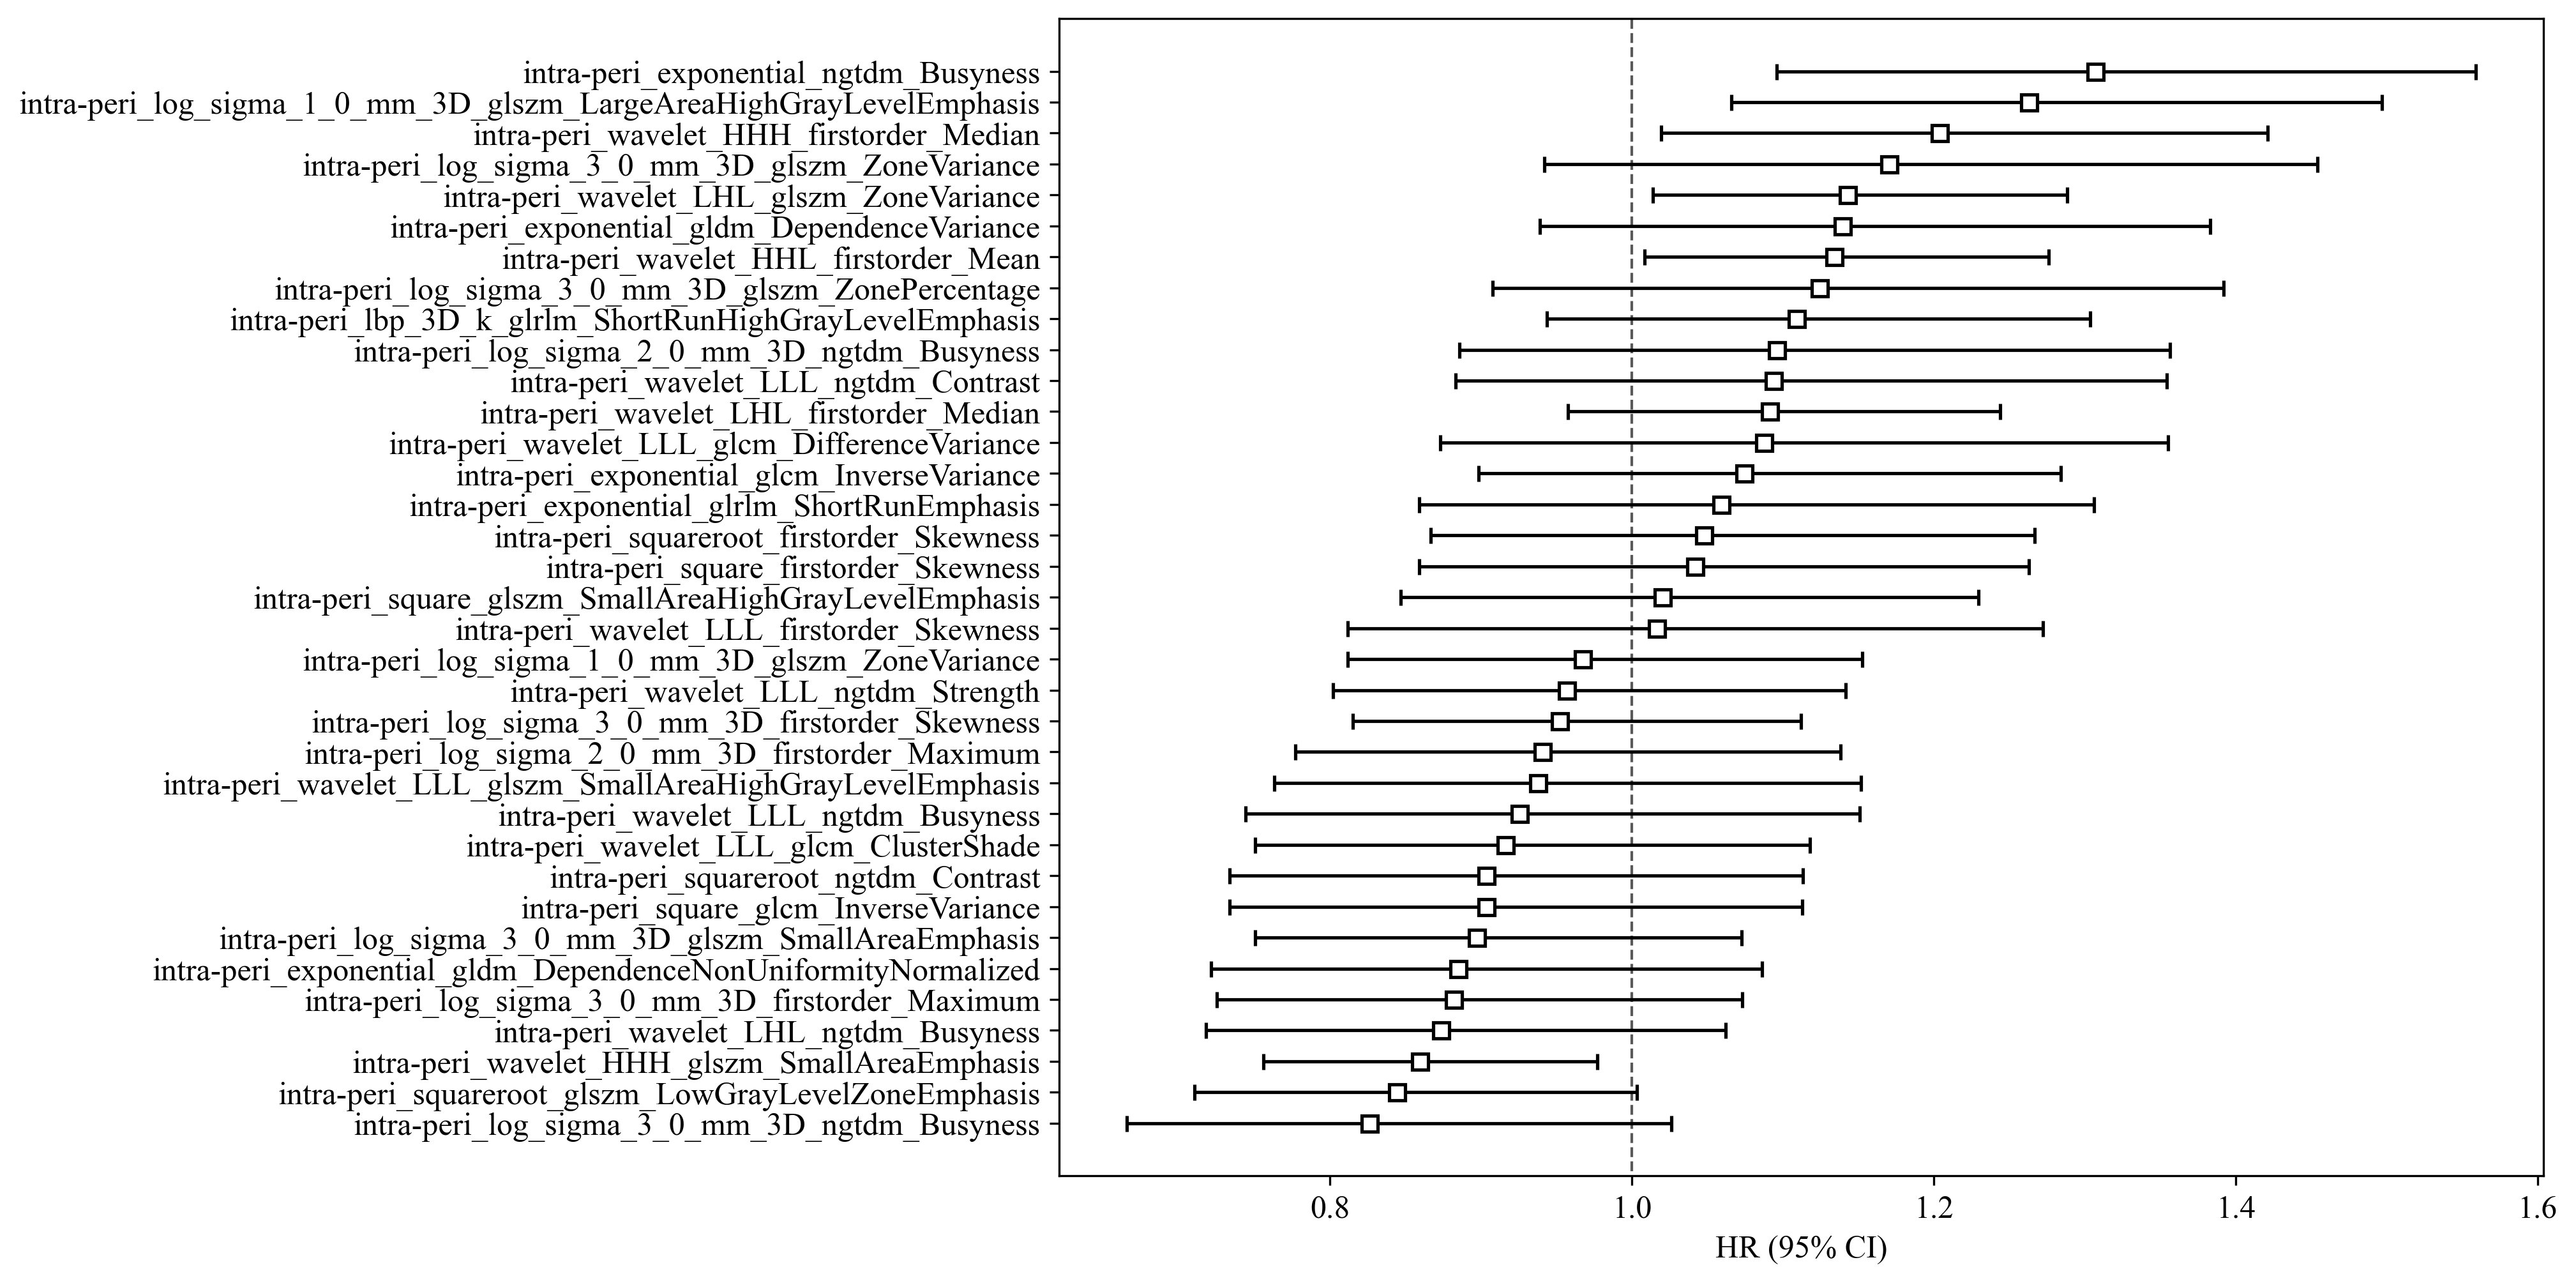

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
cph.plot(hazard_ratios=True)
plt.savefig(f'img/{task_type}feature_pvalue.svg')
plt.show()

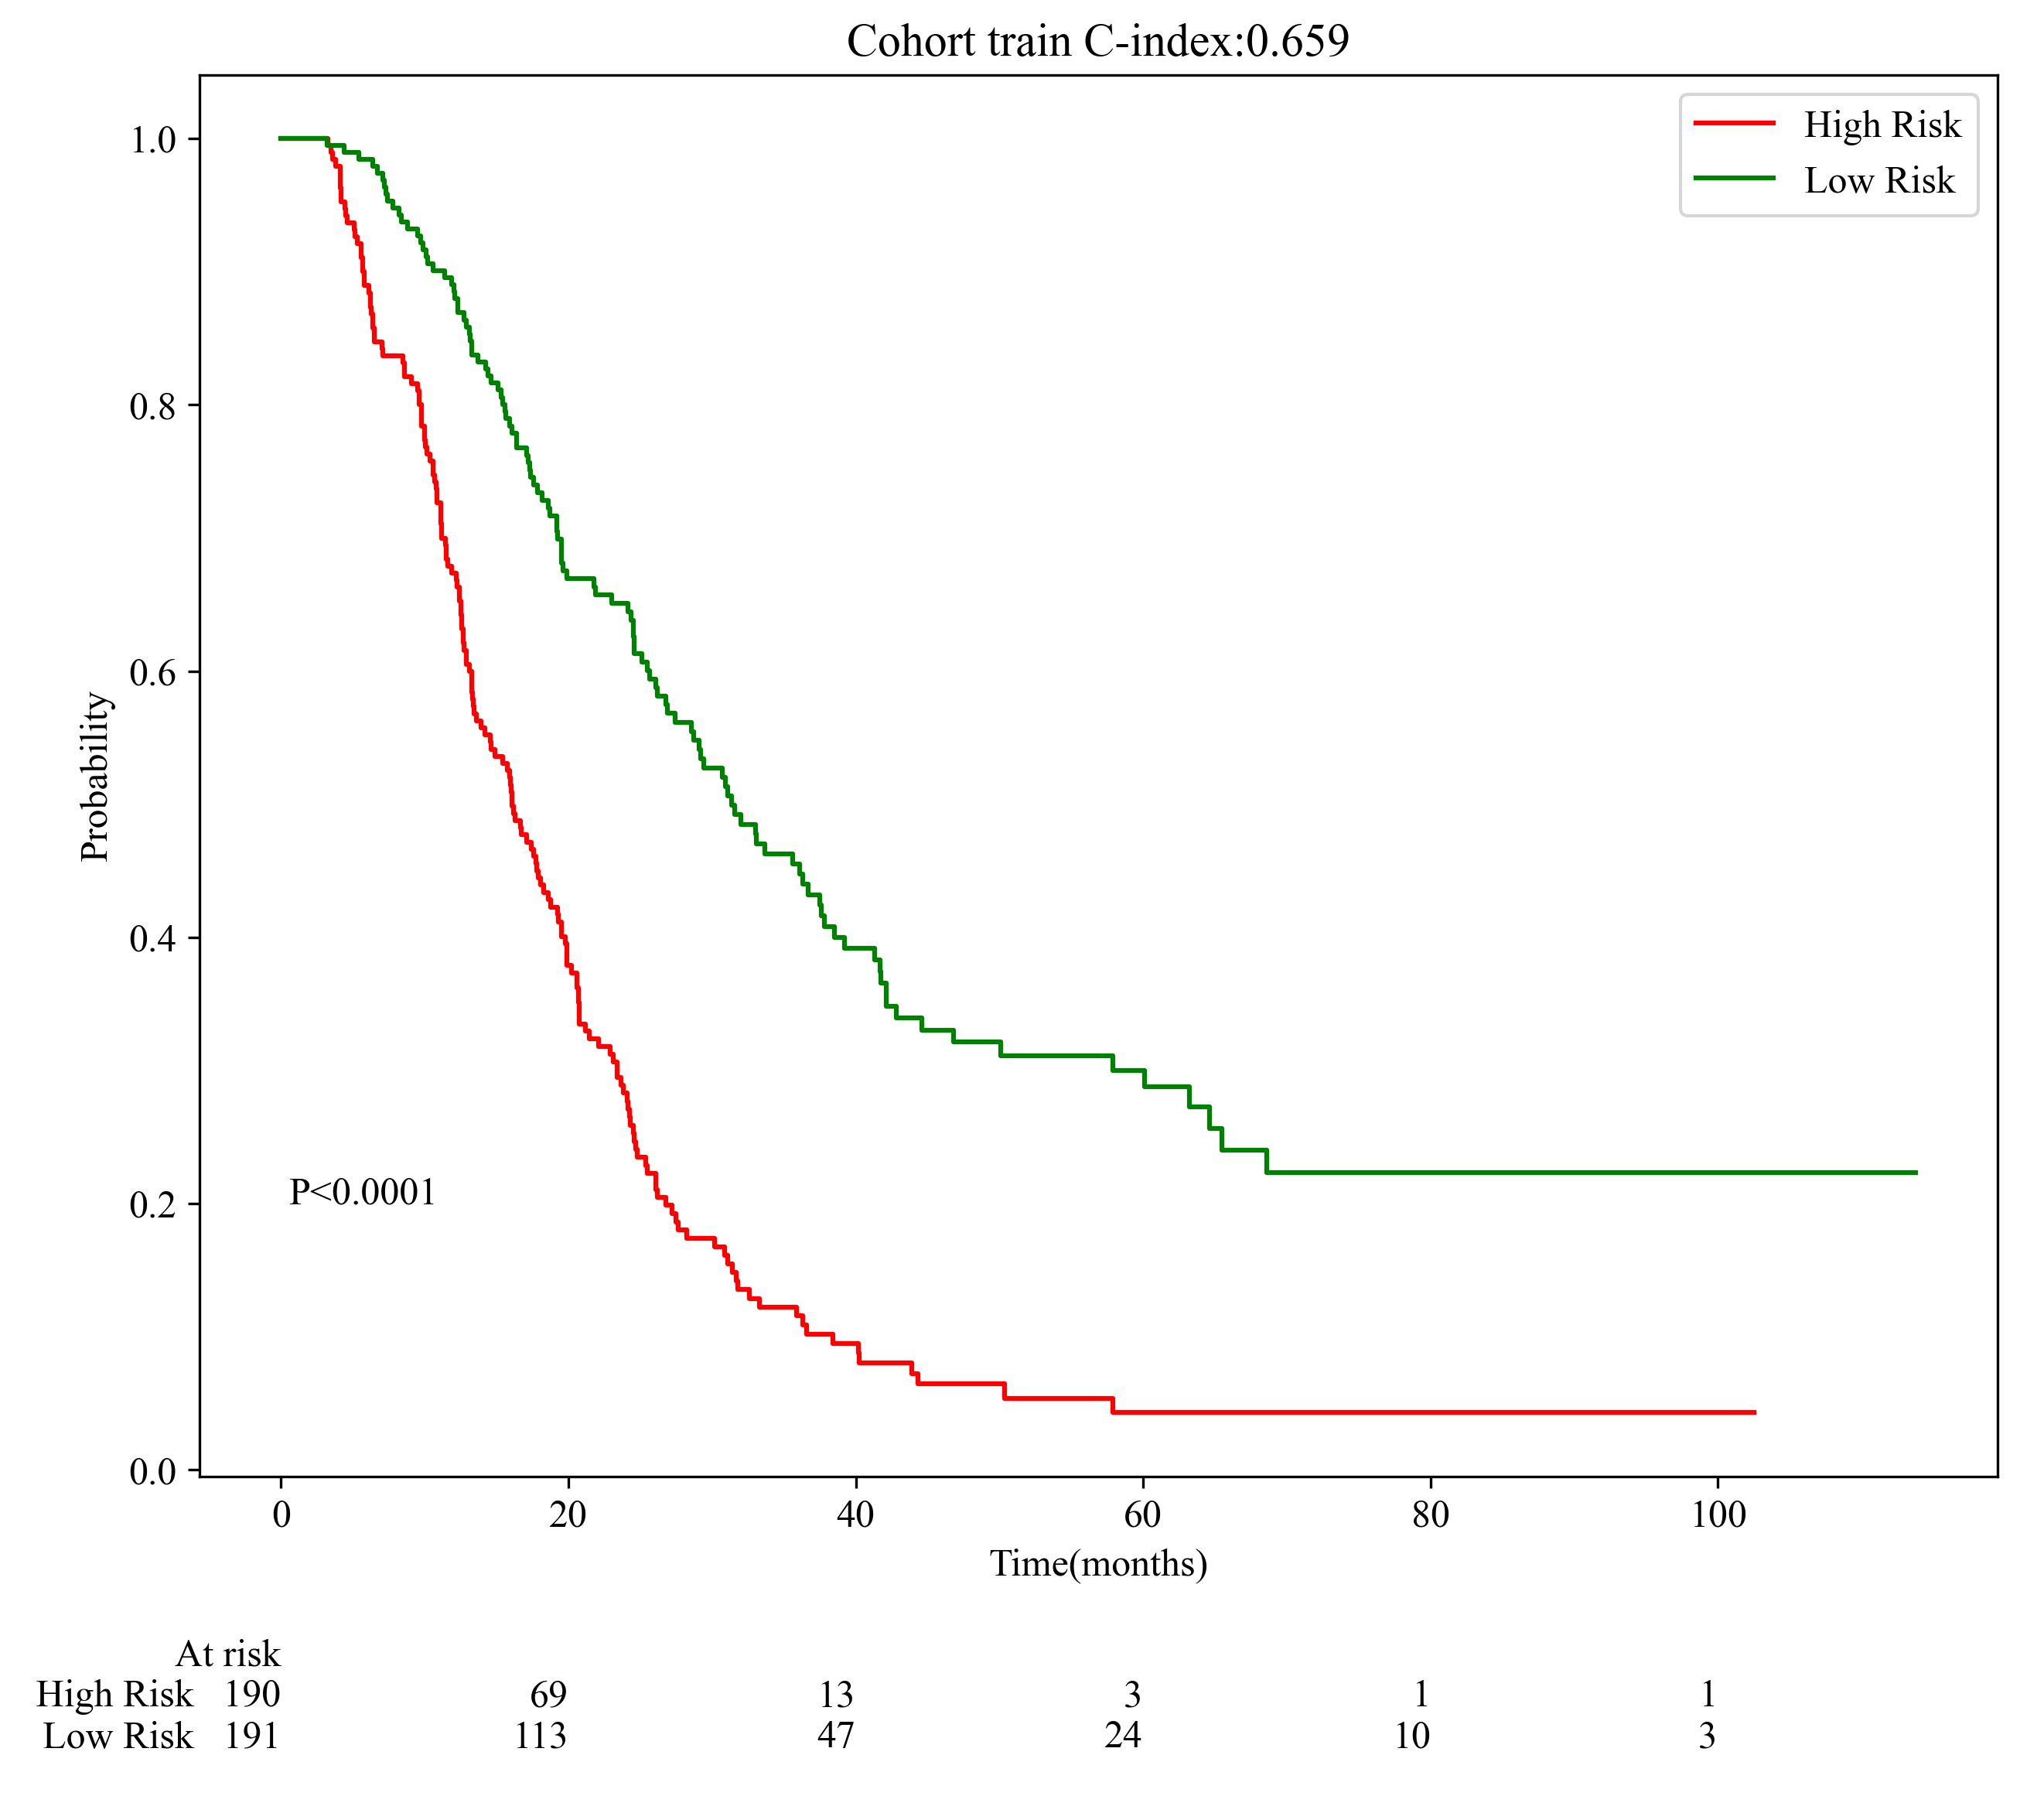

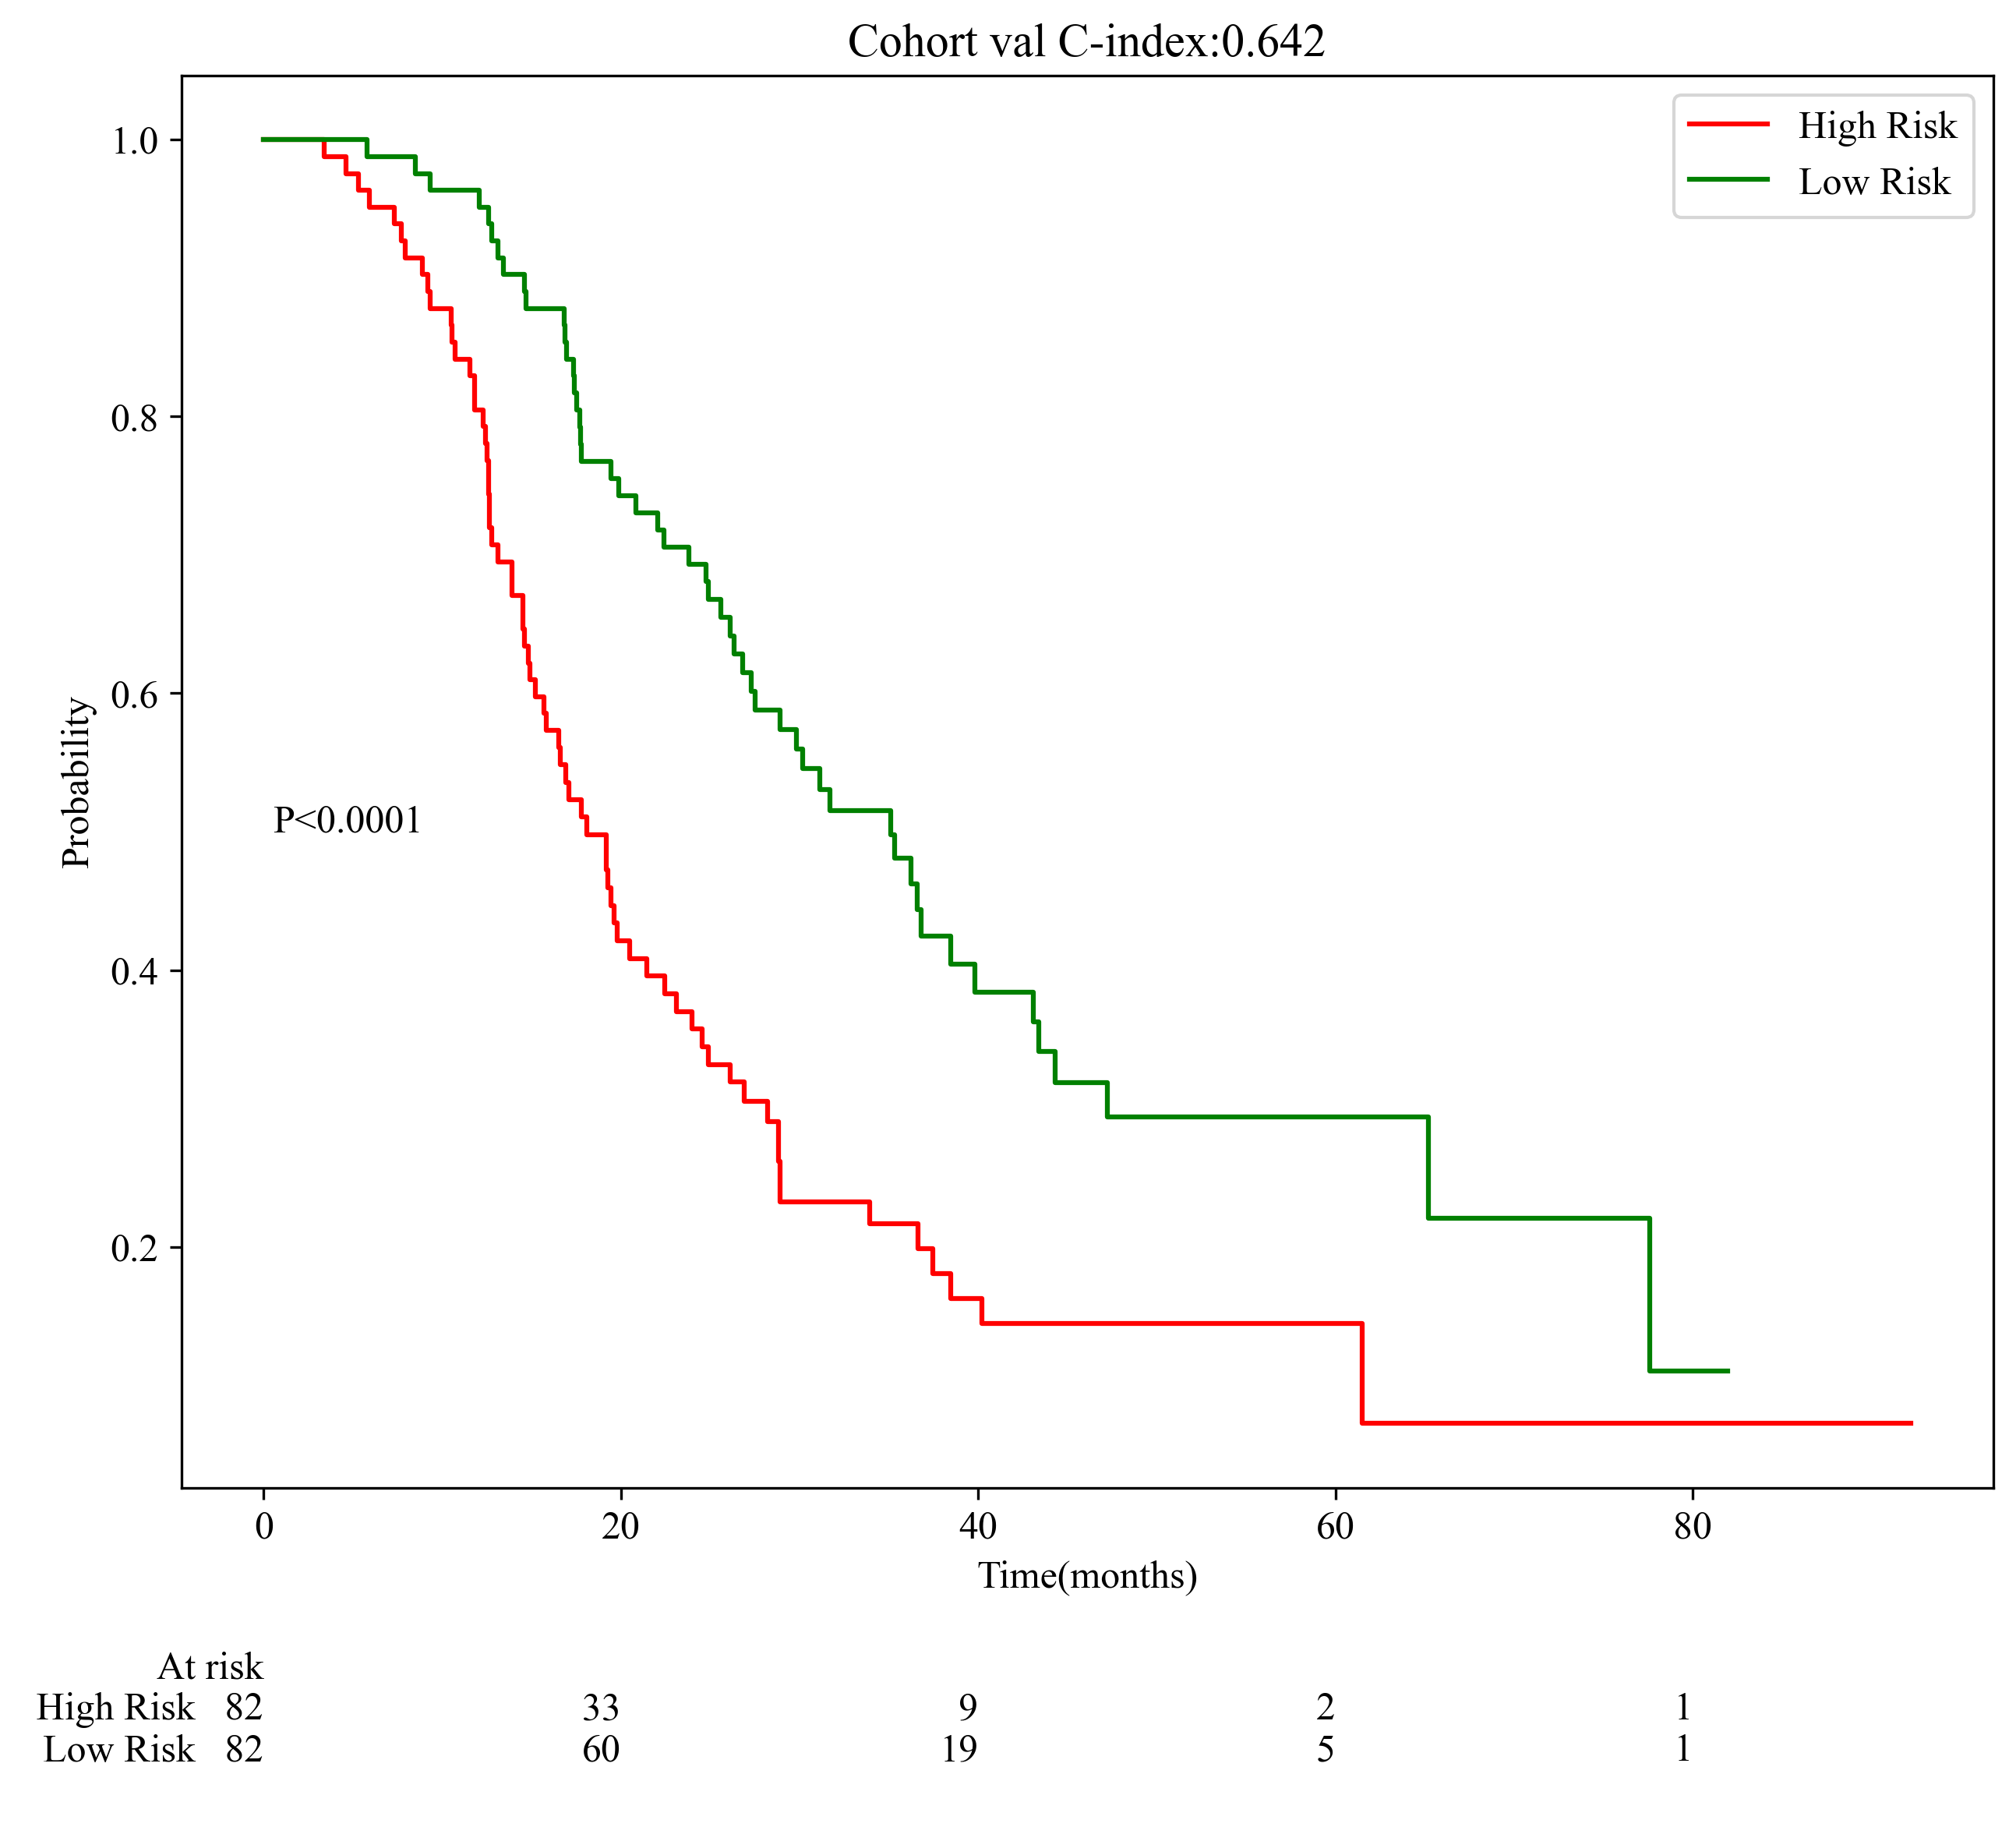

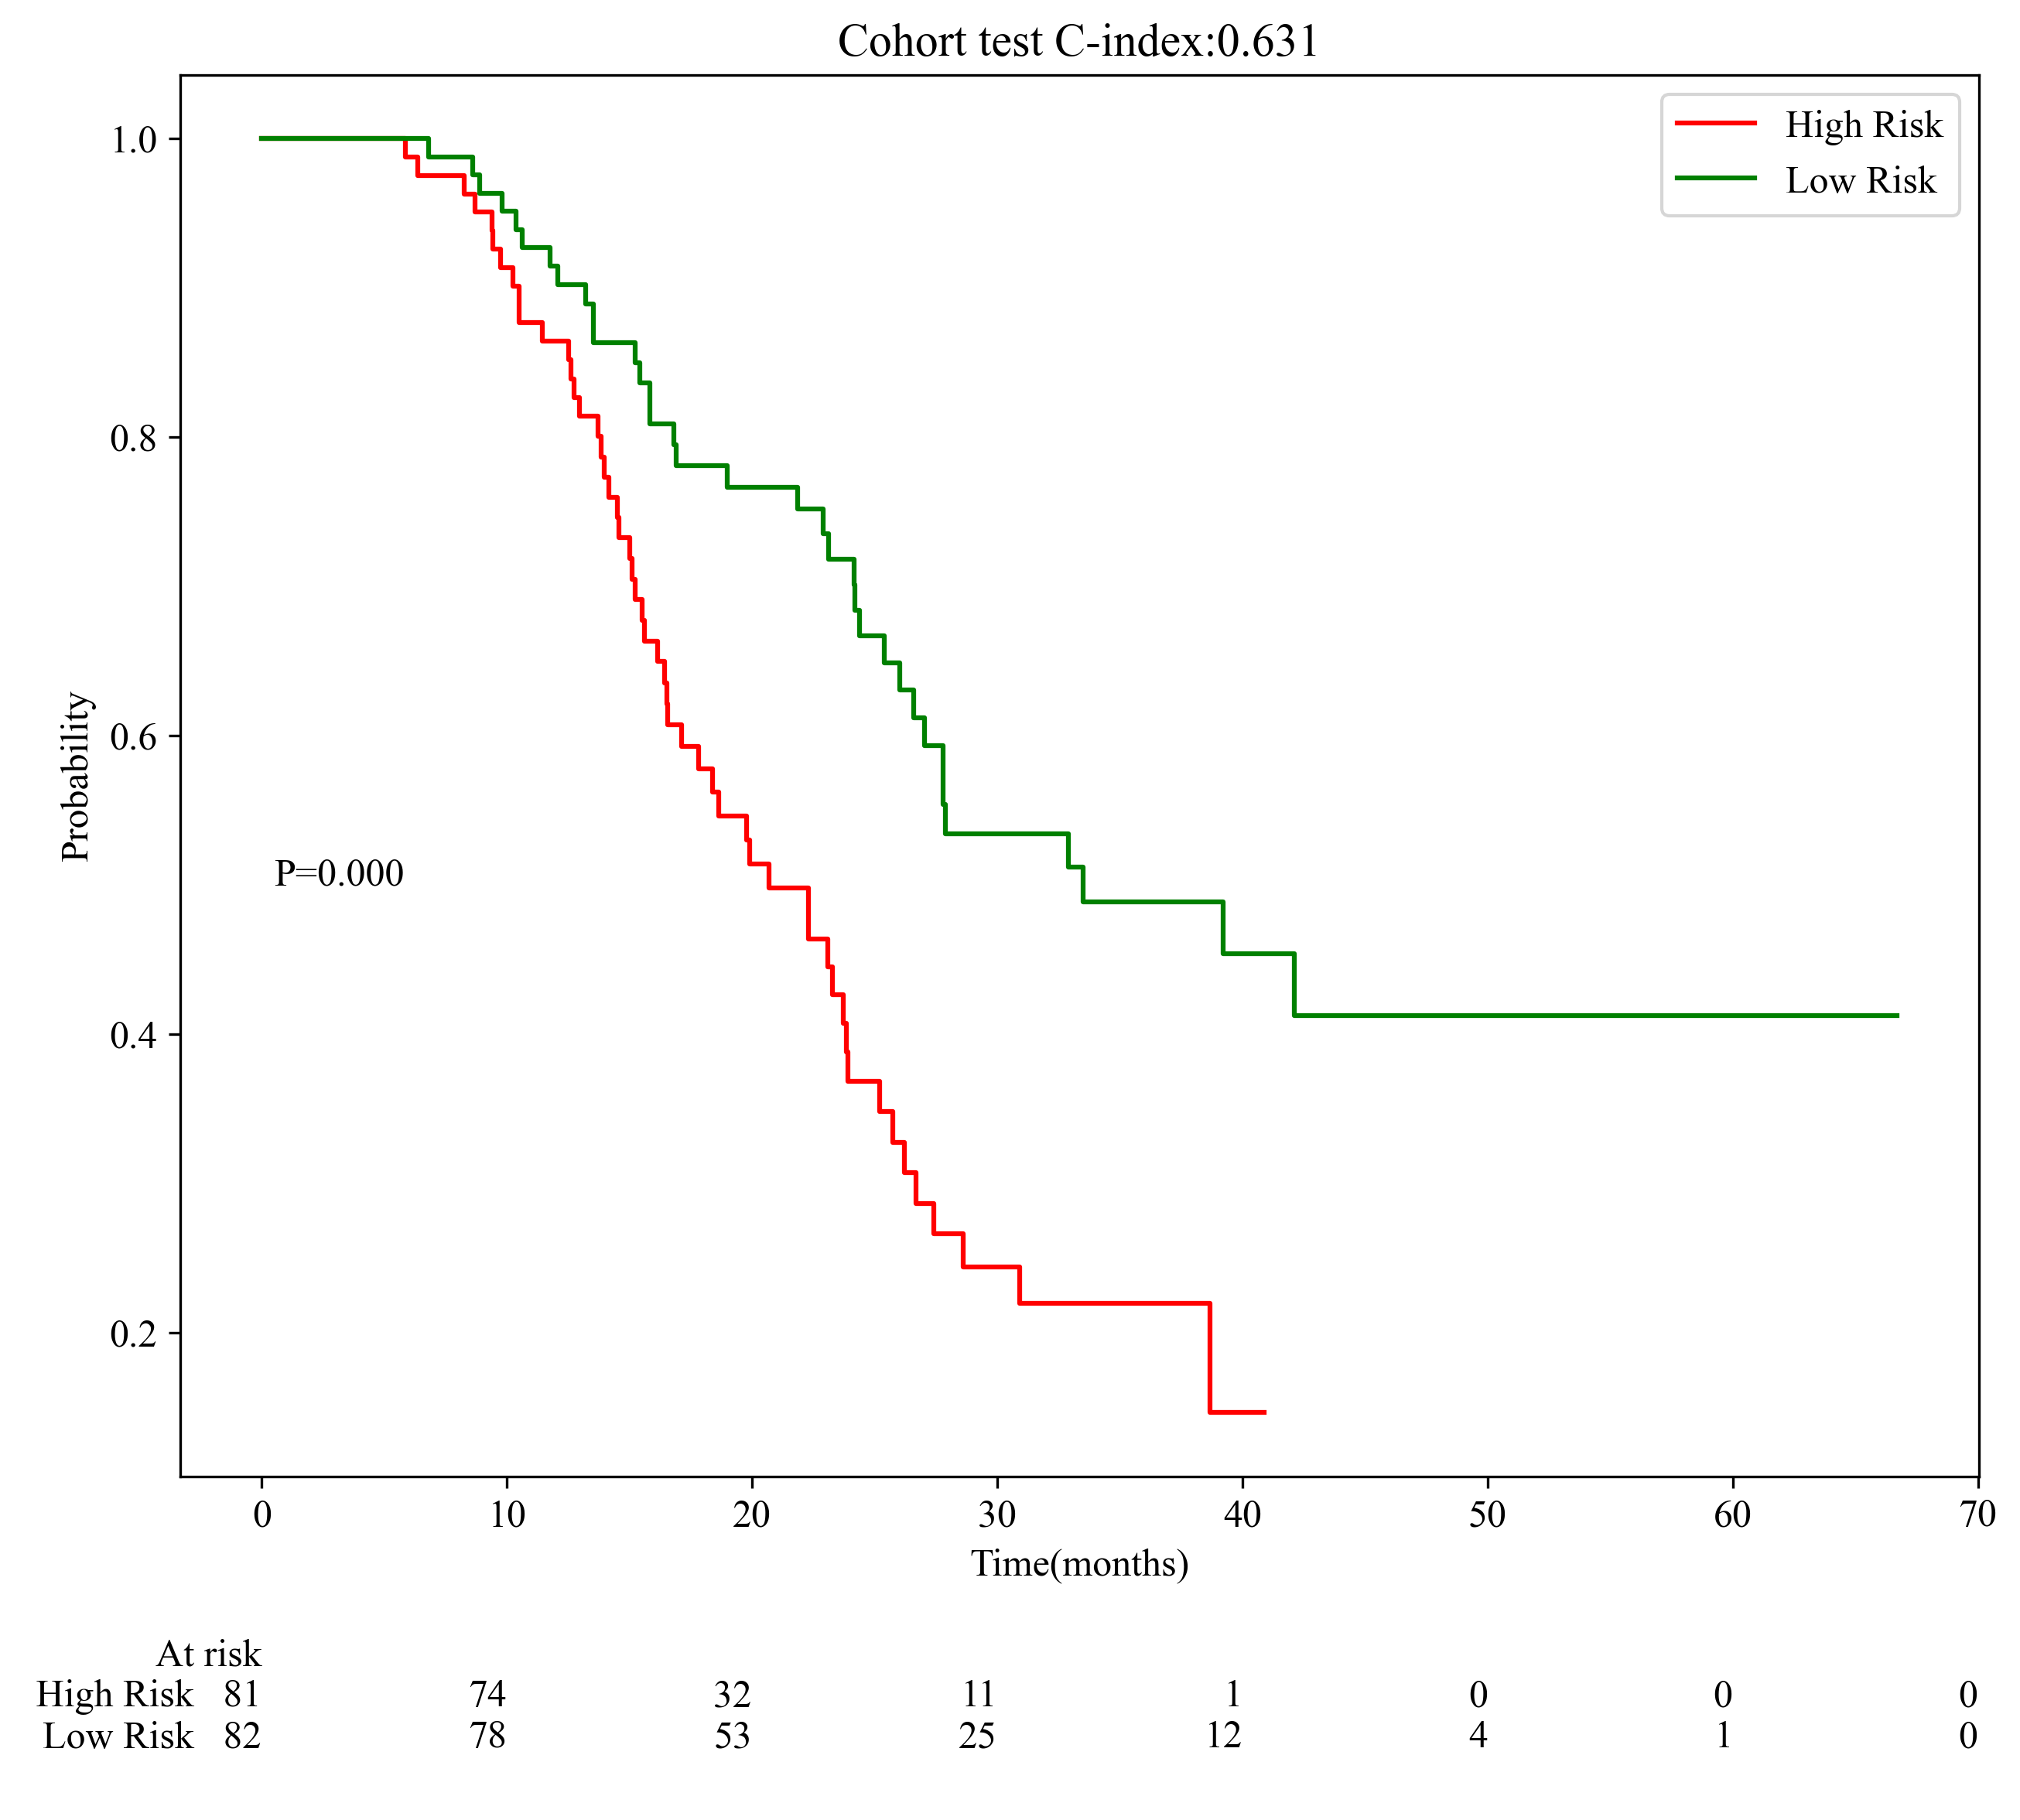

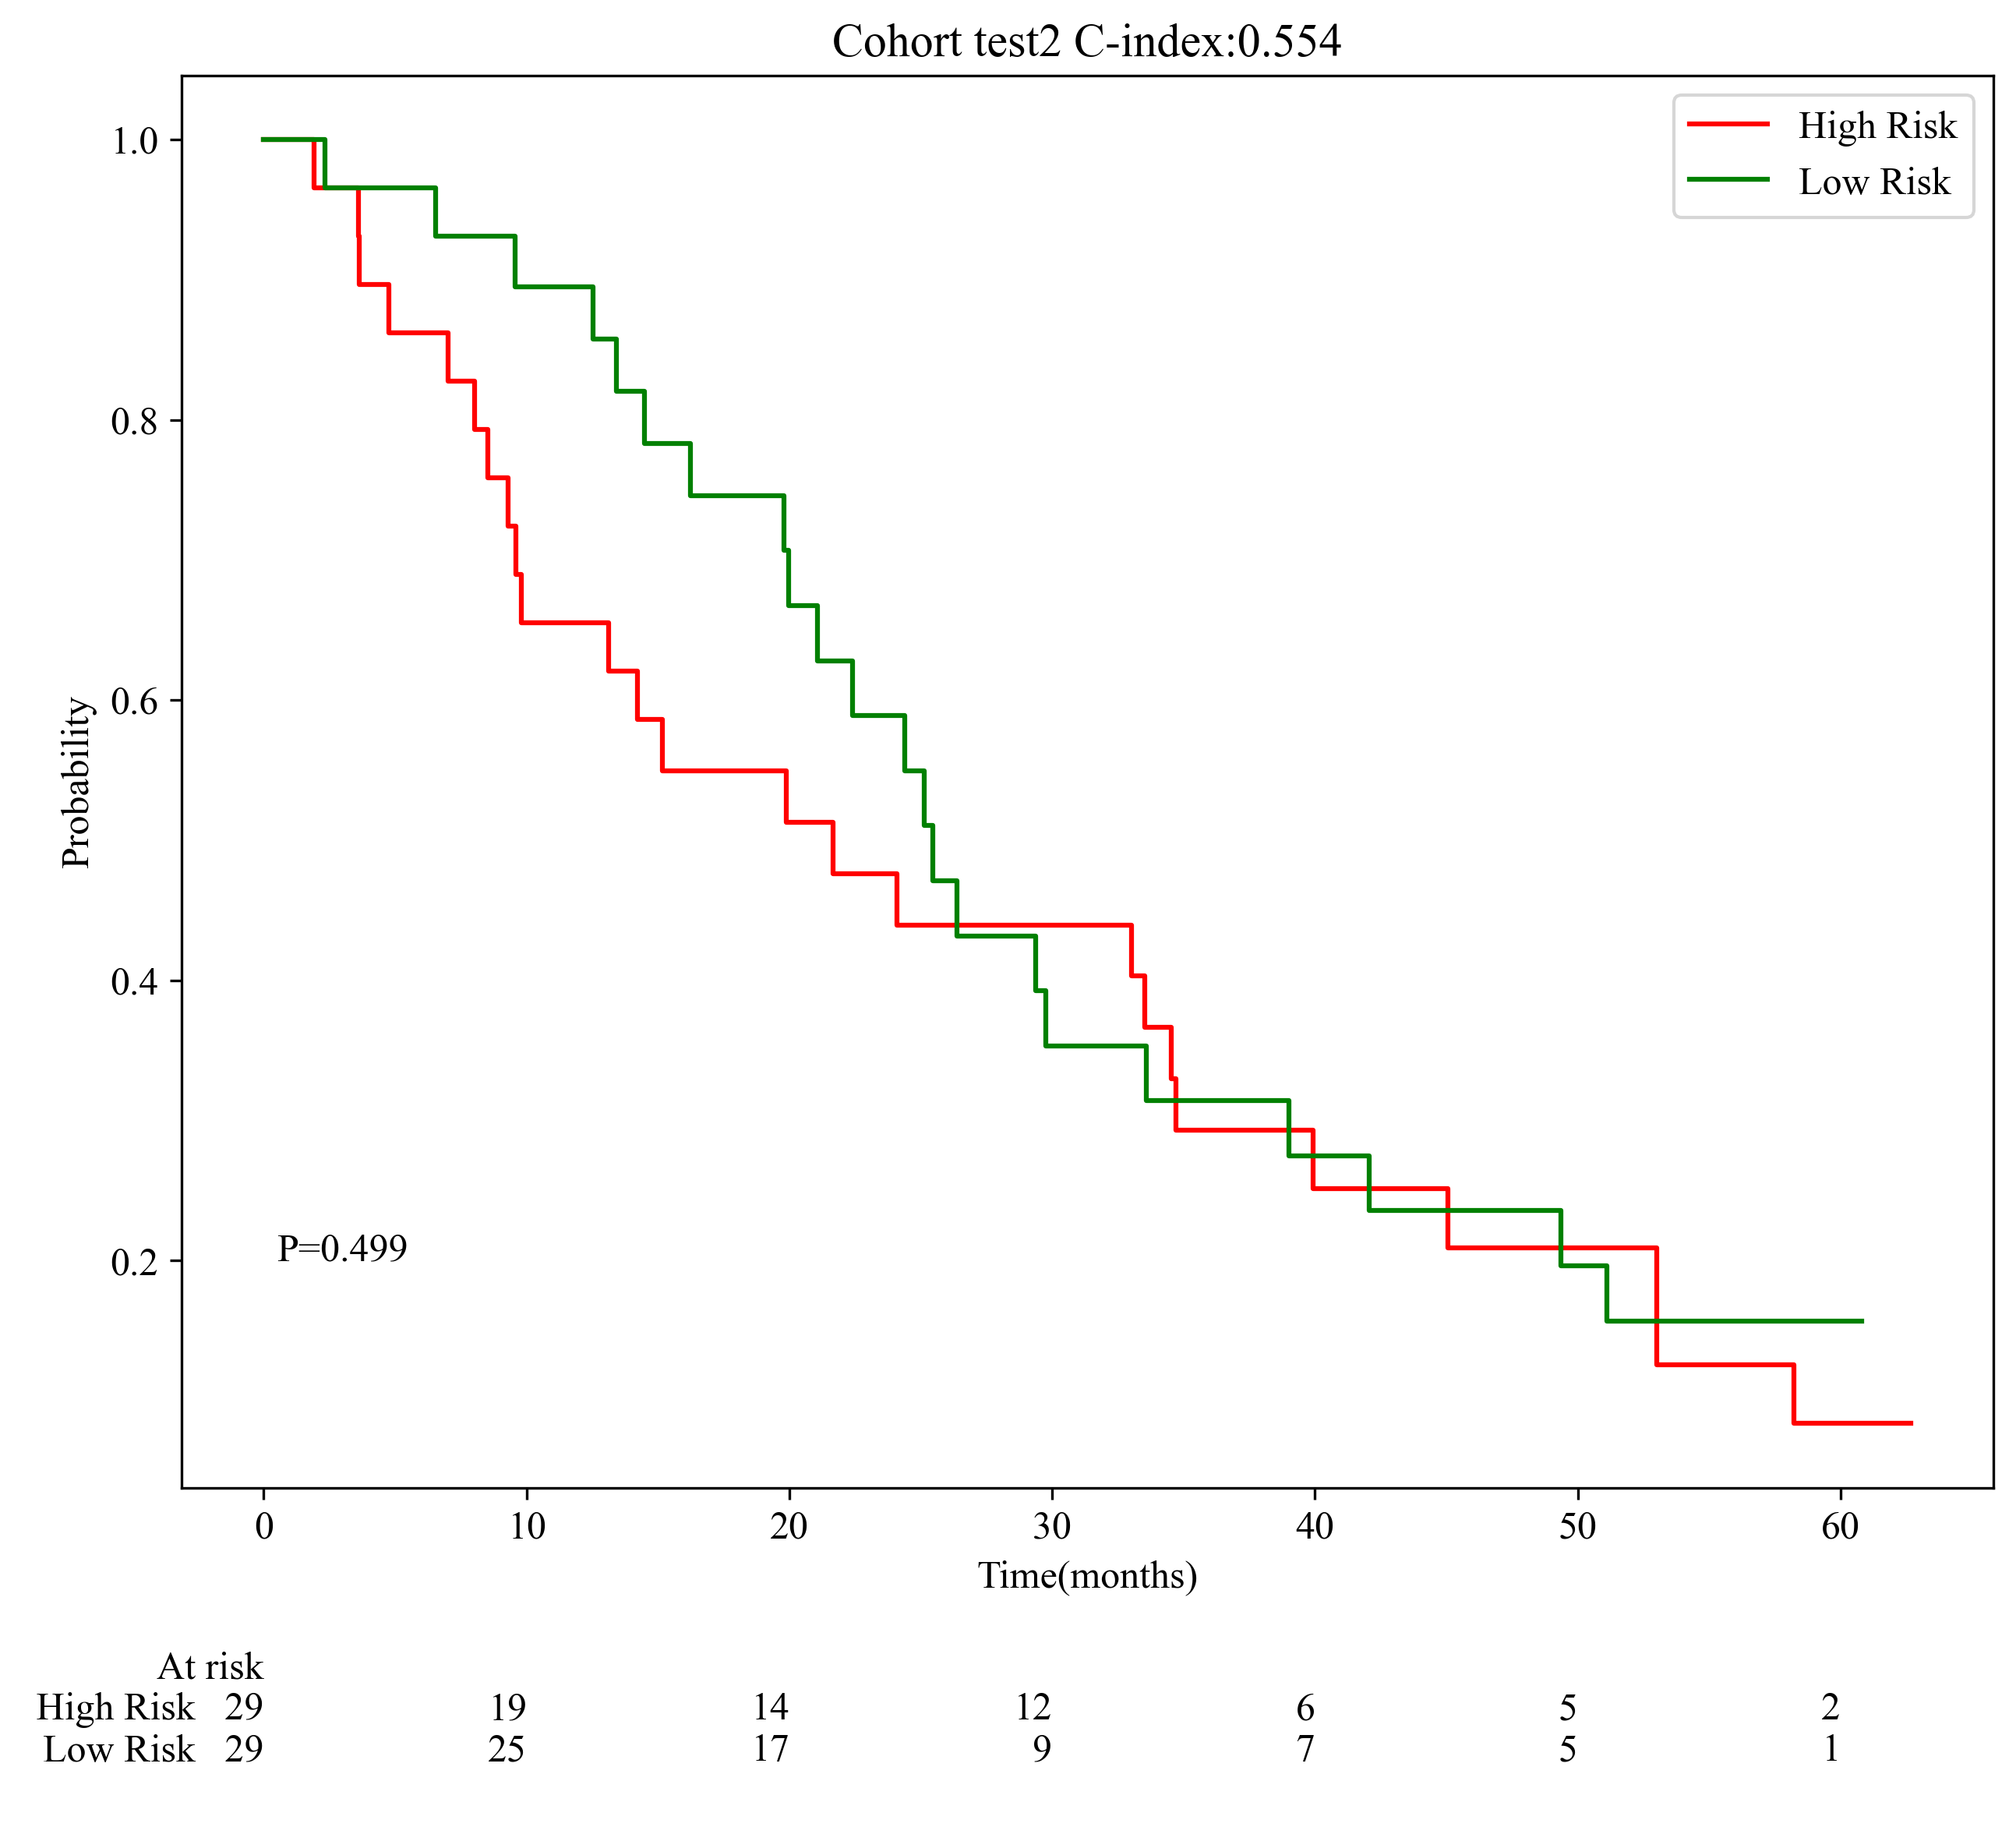

In [17]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

thres = 1e-4
bst_split = {'train': 2.0, 'val':1, 'test': 1}
loc = {'train': 0.2, 'val':0.5, 'test': 0.5}
for subset, test_data in val_datasets.items():
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
    # 根据模型预测的生存时间与人群中位数进行分组
    # y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
    # cox_data = pd.concat([test_data, y_pred], axis=1)
    # mean = cox_data.describe()[0.5]['mean']
    # cox_data['HR'] = cox_data[0.5] < mean

    # 根据模型预测HR的分位数进行分组
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > mean
    
    # 根据模型预测HR进行分组
#     cox_data['HR'] = cox_data[0] > 1
#     cox_data['HR'] = cox_data[0] > bst_split[subset]
    cox_data.to_csv(f'features/{task_type}cox_data_{subset}.csv', index=False)  # 这行是新增的导出代码

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = f"={results.p_value:.3f}" if results.p_value > thres else f'<{thres}'
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}")
    plt.ylabel('Probability')
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r', ci_show=False)
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g', ci_show=False)
    plt.text(0.5, loc[subset] if subset in loc else 0.2, f"P{p_value}")
    plt.xlabel('Time(months)')
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()

In [18]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions

os.makedirs('results', exist_ok=True)
info = []
for subset, test_data in val_datasets.items():
    if subset in get_param_in_cwd('subsets'):
        results = get_prediction(cph, test_data, ID=test_data['ID'])
        results.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
        results['group'] = subset
        info.append(results)
        pd.merge(results, label_data[['ID', event_col, duration_col]], on='ID', how='inner').to_csv(f'features/{task_type}4xtile_{subset}.txt', 
                                                                                                    index=False, sep='\t')
info = pd.concat(info, axis=0)
info

ID     HR  expectation  group
0         bianjiePVP.nii.gz  1.513       18.655  train
2          caibinPVP.nii.gz  0.286       69.520  train
7    caiqingxiangPVP.nii.gz  0.961       29.457  train
10       caiyunboPVP.nii.gz  0.918       30.792  train
12     caoguofangPVP.nii.gz  0.654       41.667  train
..                      ...    ...          ...    ...
761      zzC3N-02997.nii.gz  0.590       45.199  test2
762      zzC3N-02998.nii.gz  1.500       18.825  test2
763      zzC3N-03000.nii.gz  0.699       39.454  test2
764      zzC3N-03007.nii.gz  1.332       21.229  test2
765      zzC3N-03670.nii.gz  1.120       25.308  test2

[766 rows x 4 columns]